In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(SCRIPT_DIR)

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from utils import show_weights, plot_metrics, plot_embeddings, generate_aug_from_bool_aug, fit_classifiers, evaluate_classifiers
from data.loader import generate_cube_data

In [2]:
os.chdir('..')

In [3]:
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


In [10]:
# load invkd, spur validation (for fitting lin classifier) and test data
n = 50000
invkd_dict = generate_cube_data(n=n, v=n, d=25, k=5, aug='add', label='invkd')
spur_dict = generate_cube_data(n=n, v=n, d=25, k=5, aug='add', label='spur')

invkd_val, invkd_val_labels = invkd_dict['val'][0][:(n//2)], invkd_dict['val'][1][:(n//2)]
invkd_test, invkd_test_labels = invkd_dict['val'][0][(n//2):], invkd_dict['val'][1][(n//2):]
spur_val, spur_val_labels = spur_dict['val'][0][:(n//2)], spur_dict['val'][1][:(n//2)]
spur_test, spur_test_labels = spur_dict['val'][0][(n//2):], spur_dict['val'][1][(n//2):]

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# split evaluate_embeddings into fitting linear classifier, and getting test scores

def fit_classifiers(dirs, val, val_labels):
    """
    Fit linear classifier on each of representation functions in dirs, using validation data. 
    Returns: (backbones, classifiers)
        backbones: list of backbones/representation functions, one per directory
        classifiers: list of trained nn.Linear modules, one per directory
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # prepare datasets
    val_dataset = TensorDataset(val, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128)

    backbones = []
    classifiers = []
    for idx, dir in enumerate(dirs):
        # print(f'Run {idx+1}')
        # load embedding function, create linear classifier
        run_dict = torch.load(os.path.join(dir, 'run_dict'))
        weights = run_dict['model_weights']
        emb_dim = run_dict['args'].emb_dim
        backbone = nn.Linear(weights['weight'].shape[1], weights['weight'].shape[0]).to(device)
        backbone.load_state_dict(weights)
        # no weight updates for backbone
        for param in backbone.parameters():
            param.requires_grad = False
        linear = nn.Linear(emb_dim, 1)
        optimizer = optim.SGD(linear.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-5)
        loss_fn = nn.BCEWithLogitsLoss()
        # fit lin clf on validation data
        for epoch in range(50):
            for idx, (x, y) in enumerate(val_loader):
                x, y, = x.to(device), y.to(device)
                optimizer.zero_grad()
                logits = linear(backbone(x))
                clf_loss = loss_fn(logits.squeeze(), y)
                clf_loss.backward()
                del x, y
                optimizer.step()
            # if epoch % 10 == 0:
            #     print(f"Loss at epoch {epoch}: {clf_loss}")
        backbones.append(backbone)
        classifiers.append(linear)  
    return backbones, classifiers 

def evaluate_classifiers(backbones, classifiers, test, test_labels):
    """
    Evaluate each trained linear classifier in `classifiers` on test data.

    backbones: list of backbones/representation functions
    classifiers: list of trained nn.Linear modules
    Returns: (test_accs, avg_acc)
        test_accs: list of lin clf accuracies on test data for each linear classifier + backbone
        avg_accs: average of accs in test_accs
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset = TensorDataset(test, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128)

    test_accs = []
    for idx, (backbone, linear) in enumerate(zip(backbones, classifiers)):
        # get test set accuracy
        with torch.no_grad():
            correct = 0
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = linear(backbone(x)).flatten()
                out[out == 0] = 1 # also included same 'convention' in labeling - not sure if this makes sense or not.
                pred = (torch.sign(out) + 1)/2
                correct += (pred == y).float().sum()
        test_acc = correct / len(test_dataset)
        test_accs.append(test_acc)
    
    avg_acc = sum(test_accs) / len(test_accs)
    return test_accs, avg_acc

## Visualize covariance matrices of data for each augmentation:

Index: 27307


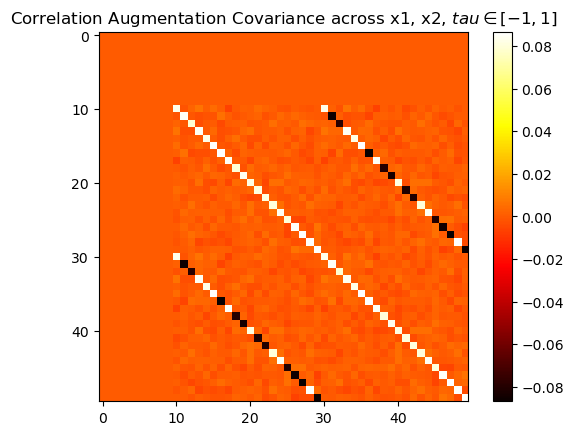

In [54]:
# corr augmentations, tau in [-1, 1]
k = 10
n_samples = 1000
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
# get random data from x1
idx = torch.randint(low=0, high=x1.shape[0], size=(1,)).item()
print(f'Index: {idx}')
x = x1[idx]
x_pairs = generate_aug_from_bool_aug(x, n_samples, k)
mean = x_pairs.mean(dim=0)
centered = x_pairs - mean
cov = centered.T @ centered / n_samples
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-1, 1]$')
plt.colorbar()
plt.show()

Index: 24346


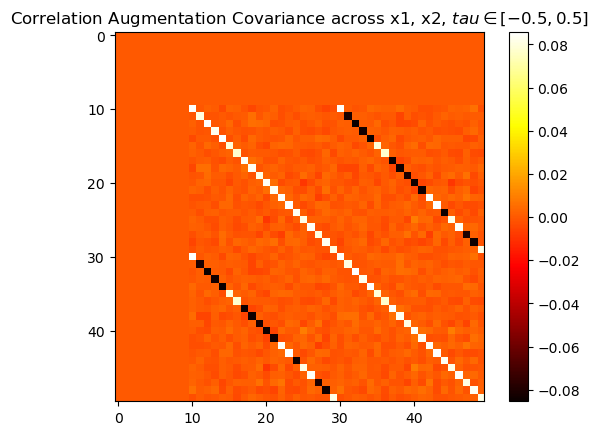

In [50]:
# corr augmentations, tau in [-0.5, 0.5]
k = 10
n_samples = 1000
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
# get random data from x1
idx = torch.randint(low=0, high=x1.shape[0], size=(1,)).item()
print(f'Index: {idx}')
x = x1[idx]
# generate positive pair data
x_pairs = generate_aug_from_bool_aug(x, n_samples, k)
mean = x_pairs.mean(dim=0)
centered = x_pairs - mean
cov = centered.T @ centered / n_samples
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.colorbar()
plt.show()

In [55]:
# plot quantity that is 0 when our assumption holds.. (see obsidian)
k = 10
n_samples = 1000
dir_invkd = './outputs/bool_corr_invkd/mssla_linear_adam_run1'
dir_spur = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict_invkd = torch.load(os.path.join(dir_invkd, 'run_dict'))
run_dict_spur = torch.load(os.path.join(dir_spur, 'run_dict'))
weights_invkd = run_dict_invkd['weights']
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
total = 0
for i in range(centered1.shape[0]):
    outer1 = torch.outer(centered1[i], centered1[i])
    outer2 = torch.outer(centered2[i], centered2[i])
    frob = torch.norm(outer1 - outer2, p='fro')
    total += frob
expected = total / centered1.shape[0]
expected
# cov1 = centered1.T @ centered1
# cov2 = centered2.T @ centered2


tensor(26.5095)

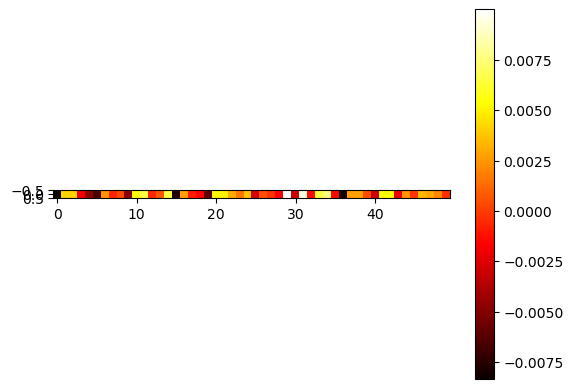

In [58]:
plt.imshow(mean1.unsqueeze(0), cmap='hot')
plt.colorbar()

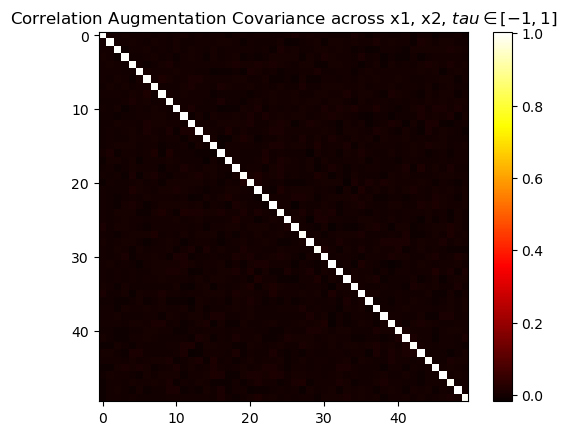

In [16]:
# corr augmentations tau in [-1, 1]
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-1, 1]$')
plt.colorbar()
plt.show()


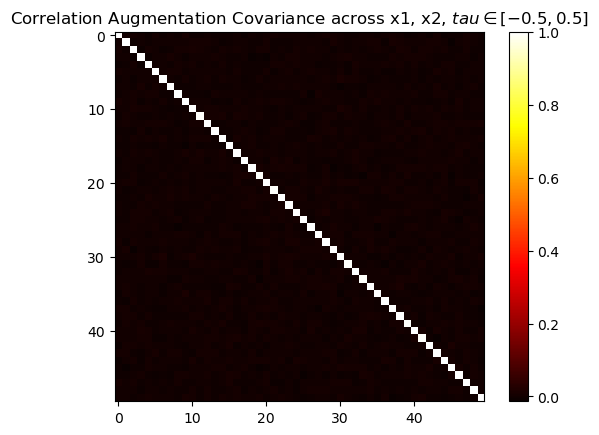

In [18]:
# corr augmentations tau in [-0.5, 0.5]
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.show()

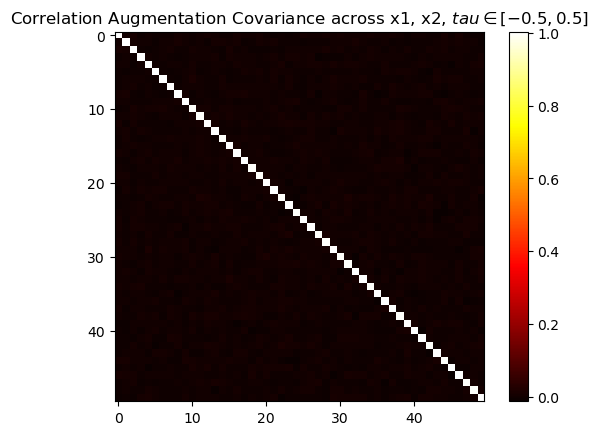

In [17]:
# corr augmentations tau in [-0.5, 0.5]
dir = './outputs/bool_corr_spur/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.show()


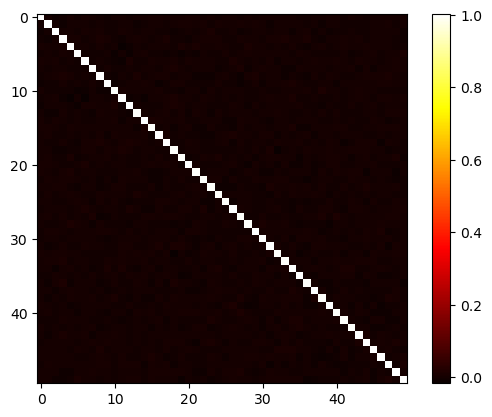

In [7]:
# add augmentations
dir = './outputs/bool_add_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.show()

In [5]:
x1.shape, mean1.shape

(torch.Size([65536, 50]), torch.Size([50]))

## Aug: Corr

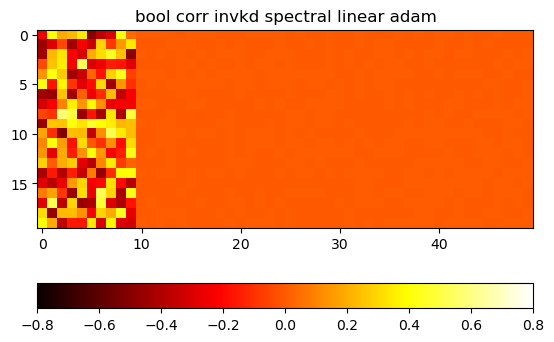

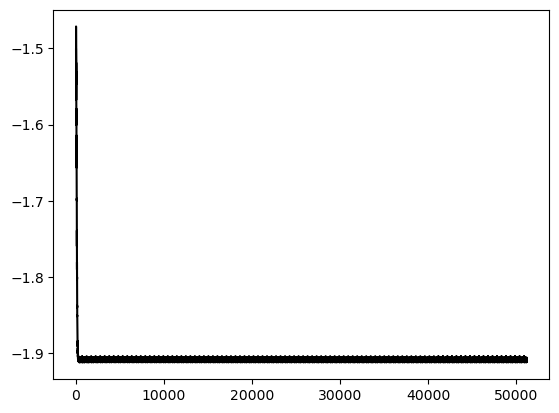

In [79]:
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
show_weights(dir, True, False)

# show_weights(dir, True, False, 'model_weights_2024-04-27_19-53-12',
# 'model_weights_2024-04-27_19-53-46',
# 'model_weights_2024-04-27_19-54-18',
# 'model_weights_2024-04-27_19-54-53',
# 'model_weights_2024-04-27_19-55-29')
plot_metrics('train_losses', True, False, dir)
# tau in [-1, 1]

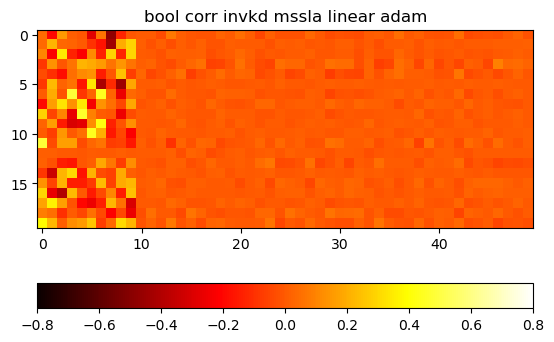

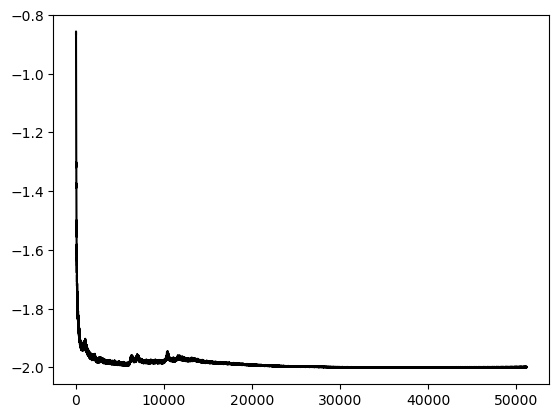

In [80]:
dir = './outputs/bool_corr_invkd/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# tau in [-1, 1]

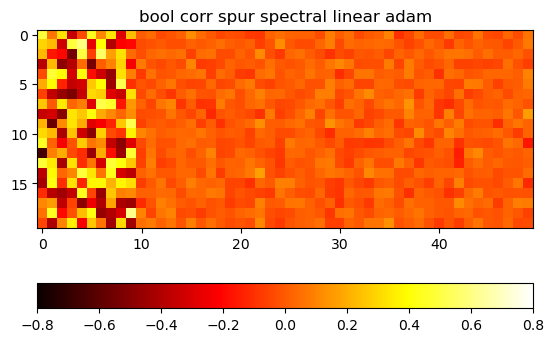

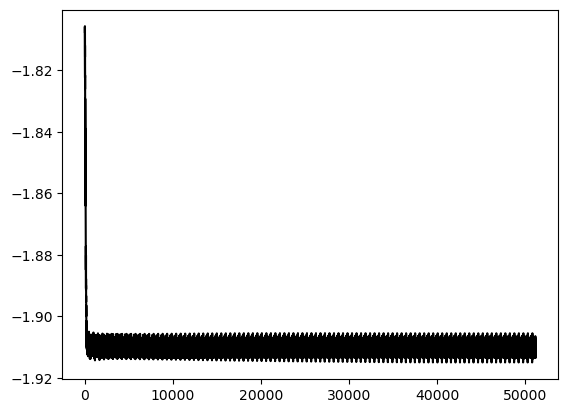

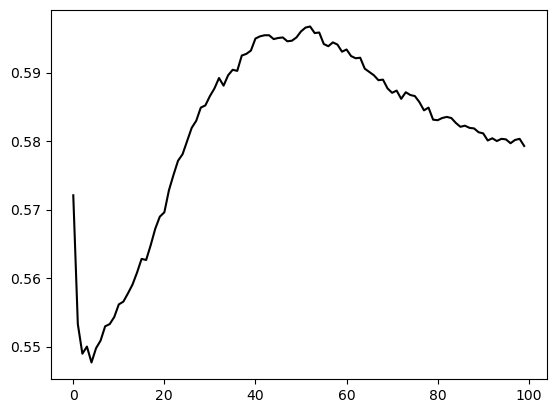

In [76]:
dir = './outputs/bool_corr_spur/spectral_linear_adam_run1'
show_weights(dir, True, False)

# show_weights(dir, True, False,
# 'model_weights_2024-04-27_20-13-01',
# 'model_weights_2024-04-27_20-13-34',
# 'model_weights_2024-04-27_20-14-07',
# 'model_weights_2024-04-27_20-14-40',
# 'model_weights_2024-04-27_20-15-12')
plot_metrics('train_losses', True, False, dir)
plot_metrics('val_accs', True, False, dir)
# tau in [-0.5, 0.5]

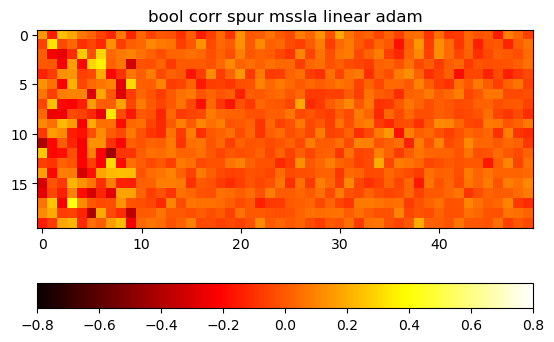

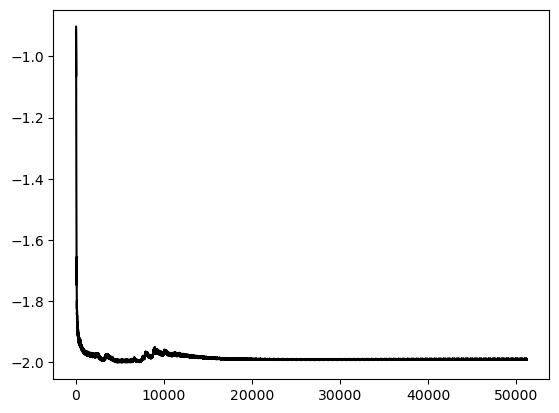

In [77]:
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
show_weights(dir, True, False)

plot_metrics('train_losses', True, False, dir)
# plot_metrics('val_accs', True, False, dir)

# tau in [-0.5, 0.5]

## Aug: Add

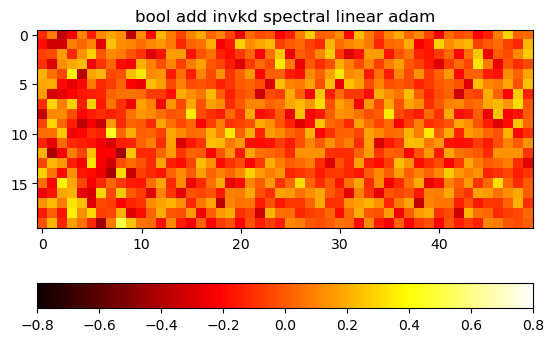

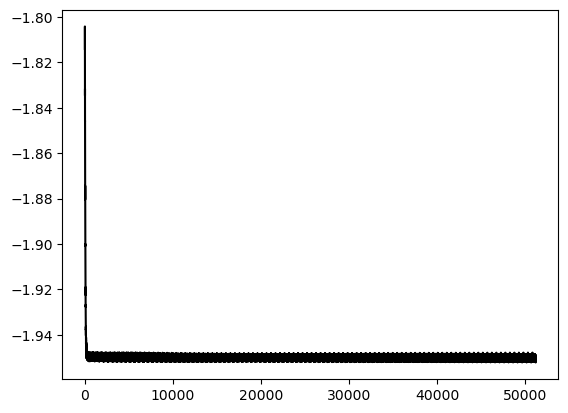

In [81]:
dir = './outputs/bool_add_invkd/spectral_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

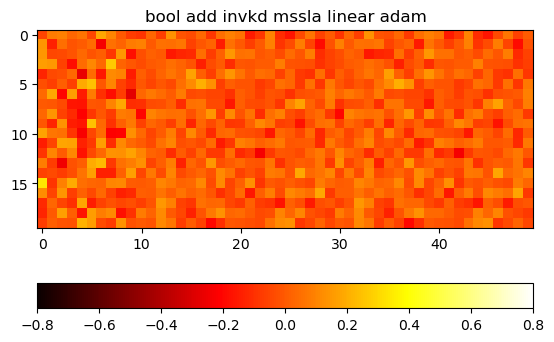

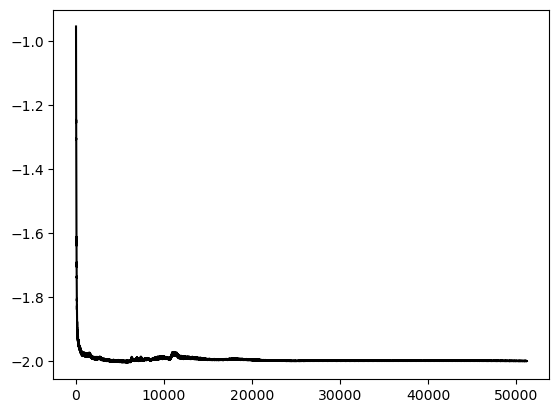

In [82]:
dir = './outputs/bool_add_invkd/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

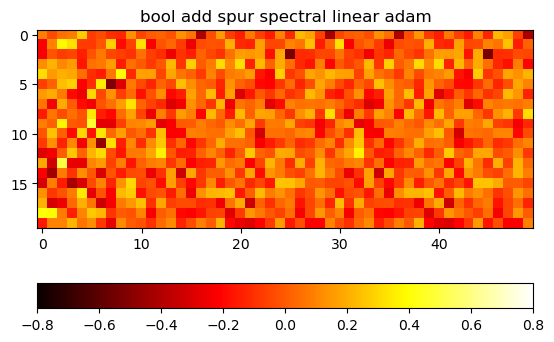

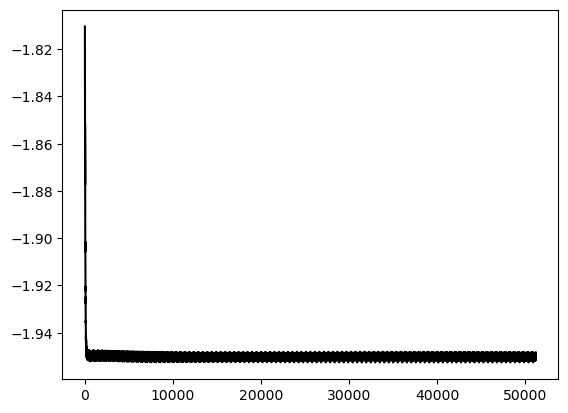

In [71]:
dir = './outputs/bool_add_spur/spectral_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

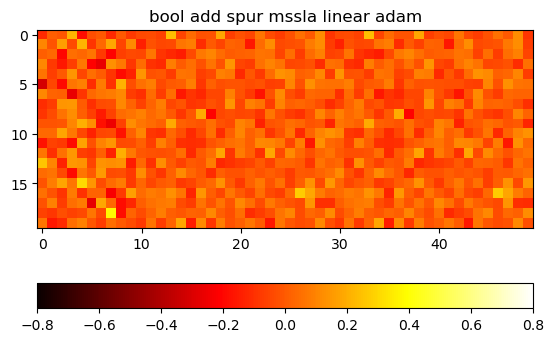

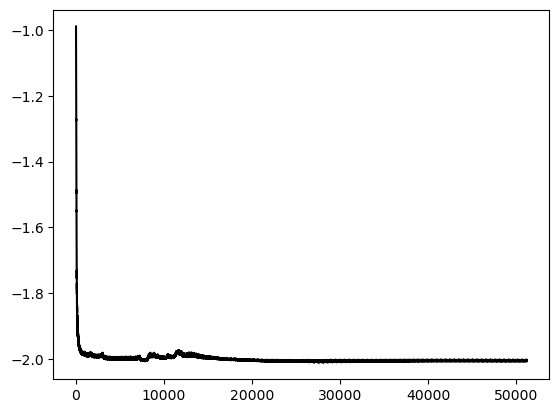

In [70]:
dir = './outputs/bool_add_spur/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

## Hyperparam tuning experiments

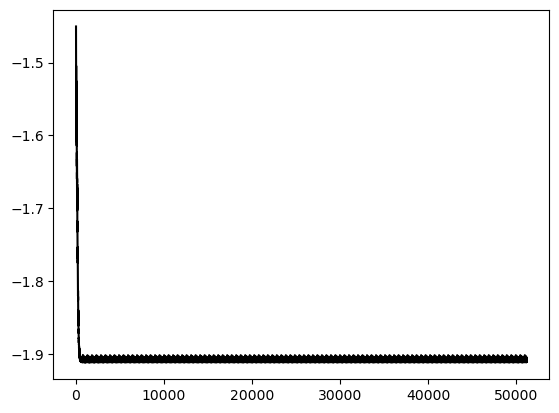

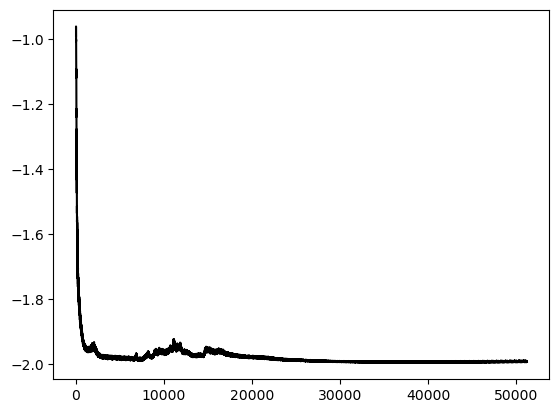

In [86]:
# lr 5e-4, tau in -1, 1
dir = './outputs/bool_corr_invkd/spectral_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# still quite shaky at the bottom.. for lr = 5e-4, adam

dir = './outputs/bool_corr_invkd/mssla_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

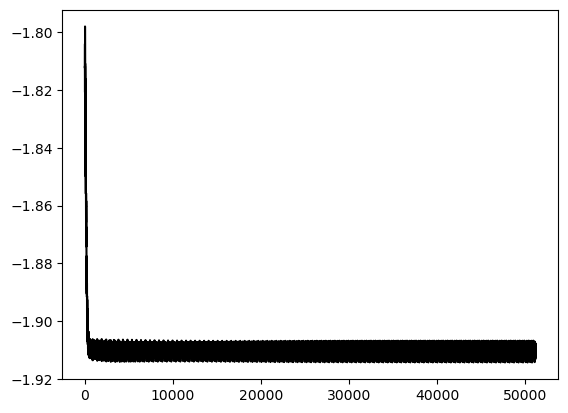

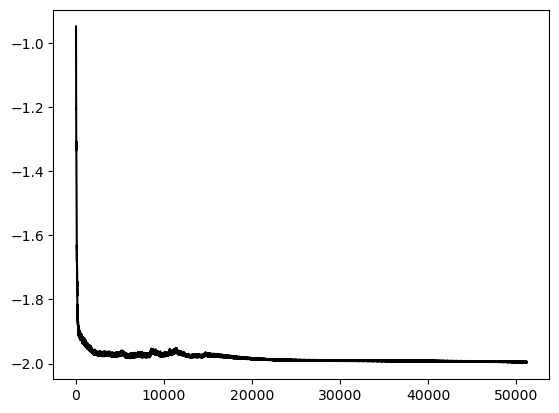

In [87]:
# lr 5e-4, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# still quite shaky at the bottom.. for lr = 5e-4, adam

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

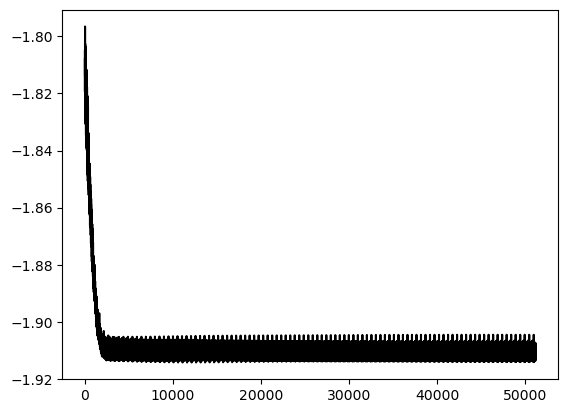

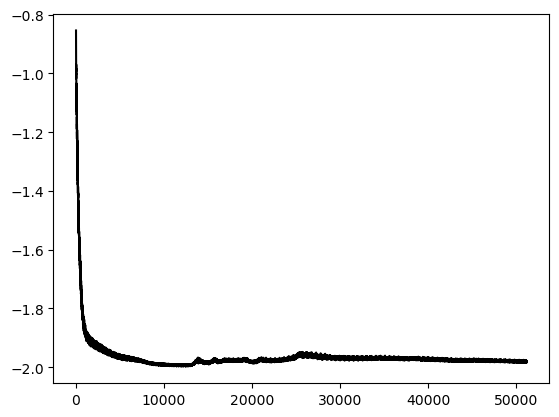

In [88]:
# lr 1e-4, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=0.0001_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

In [92]:
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


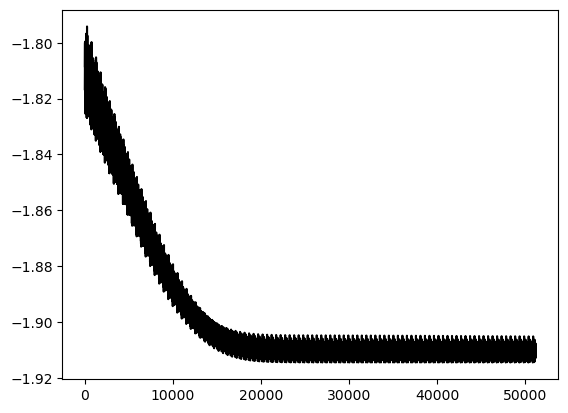

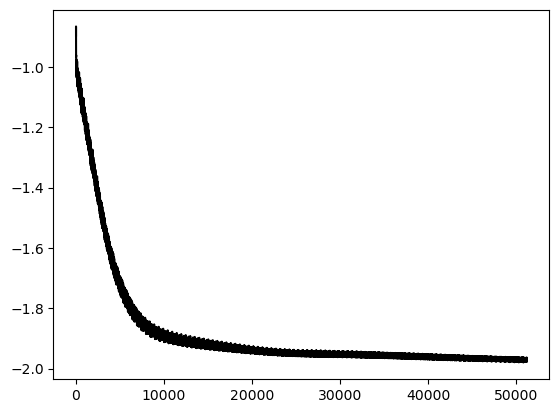

In [93]:
# lr 1e-5, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=1e-05_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

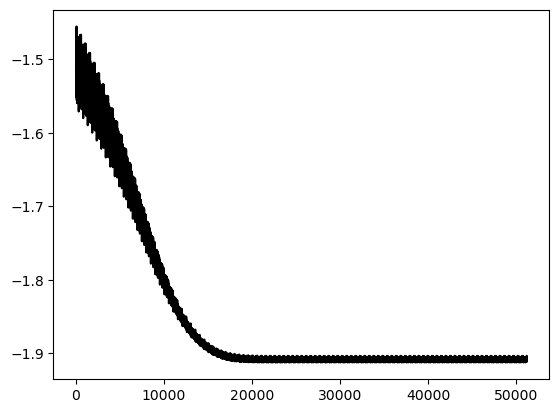

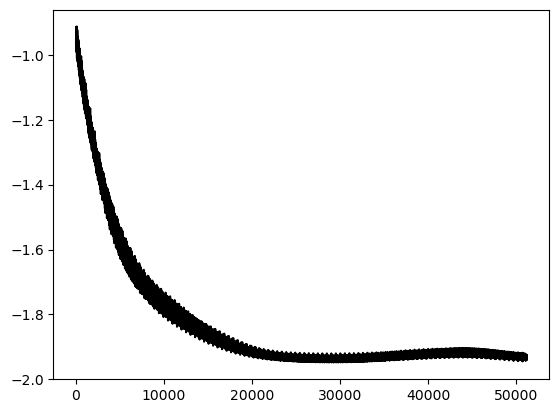

In [94]:
# Lowering learning rate only appears to make things worse
# lr 1e-5, tau in -1, 1
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=1e-05_run2'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run2'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

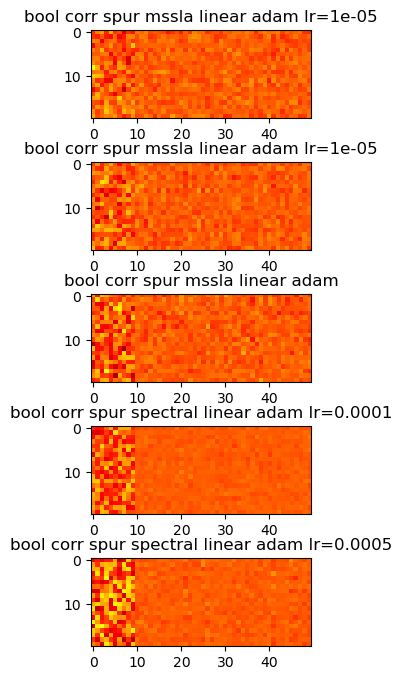

In [4]:
show_weights(
    './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run1',
    './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run2',
    './outputs/bool_corr_spur/mssla_linear_adam_run1',
    './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_run1',
    './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0005_run1',
)

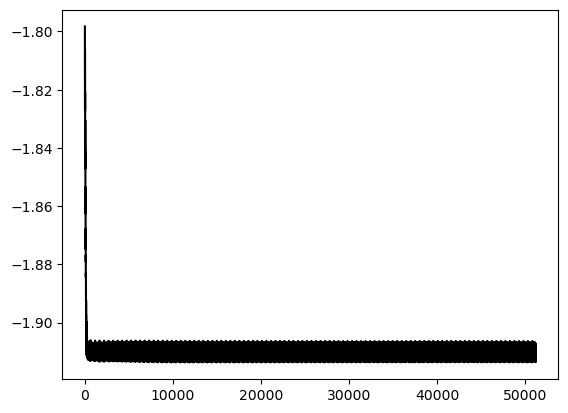

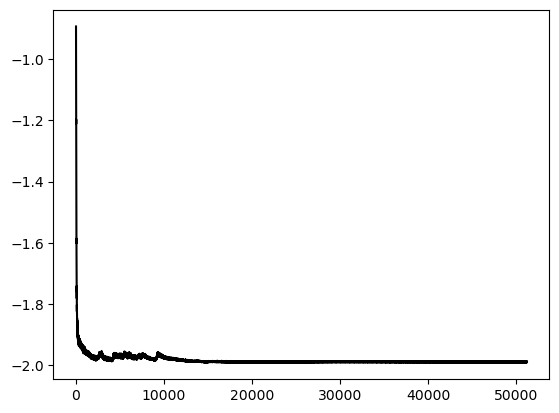

In [6]:
# Weight decay doesn't appear to do anything
# lr 1e-3, tau in +-0.5, , wd=1e-4
dir = './outputs/bool_corr_spur/spectral_linear_adam_wd=0.0001_tau_l=-0.5_tau_u=0.5_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_wd=0.0001_tau_l=-0.5_tau_u=0.5_momentum=0.9_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

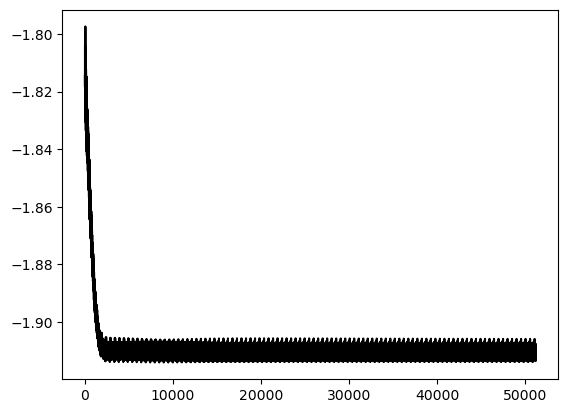

In [7]:
# lr=1e-4, wd=1e-4
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_wd=0.0001_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

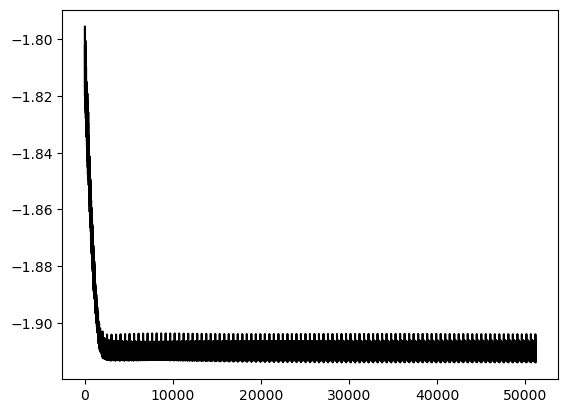

In [8]:
# Increasing weight decay to 1e-3 doesn't seem to do anything either
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_wd=0.001_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

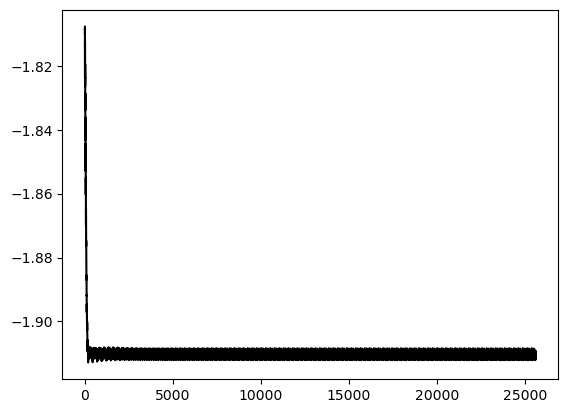

In [9]:
# Increasing batch size helps.. bs=256 for tau +- 0.5, lr=1e-3 wd=1e-5
dir = './outputs/bool_corr_spur/spectral_linear_adam_bs=256_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

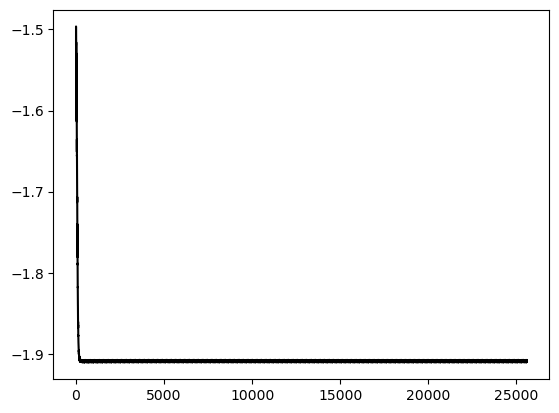

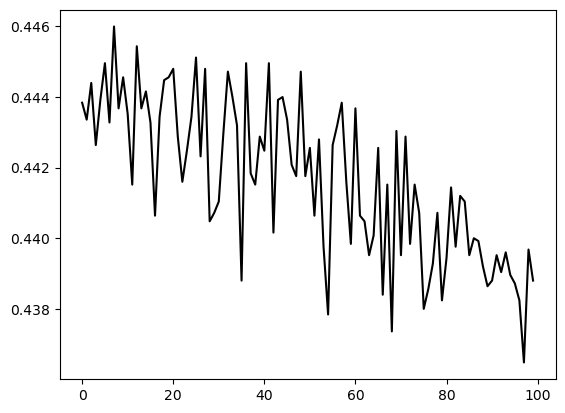

In [12]:
# bs=256 for tau in +-1 lr=1e-3 wd=1e-5
dir = './outputs/bool_corr_spur/spectral_linear_adam_bs=256_tau_l=-1.0_tau_u=1.0_run1'
plot_metrics('train_losses', True, False, dir)
plot_metrics('val_accs', True, False, dir)

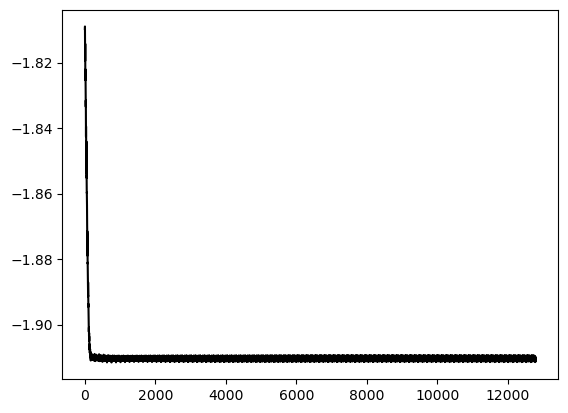

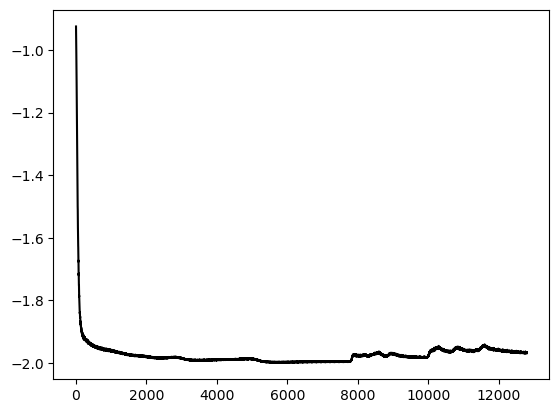

In [10]:
# bs=512 tau +- 0.5 
dir = './outputs/bool_corr_invkd/spectral_linear_adam_bs=512_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)
dir = './outputs/bool_corr_invkd/mssla_linear_adam_bs=512_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

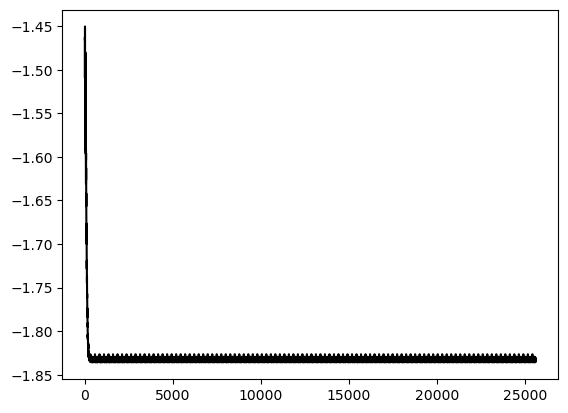

In [8]:
# halving dims (d=25, k=5, embd=10)
dir = './outputs/bool_corr_invkd/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1'
plot_metrics('train_losses', True, False, dir)
dir = './outputs/bool_corr_invkd/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1'
plot_metrics('train_losses', True, False, dir)

## Weight Matrices for Half Dim Runs (embd=10, half dims) 4 runs each

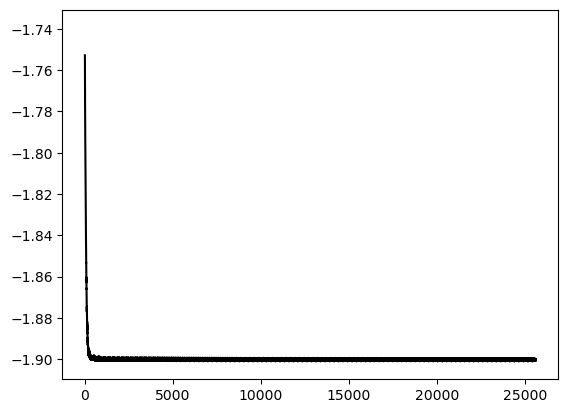

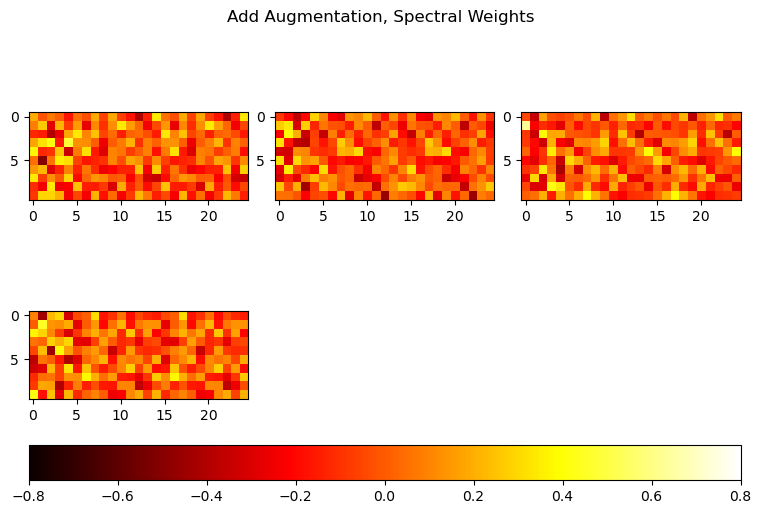

In [7]:
# aug=add, d=25, k=10, embd=10, bs=256, spectral
dirs = [
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Add Augmentation, Spectral Weights')

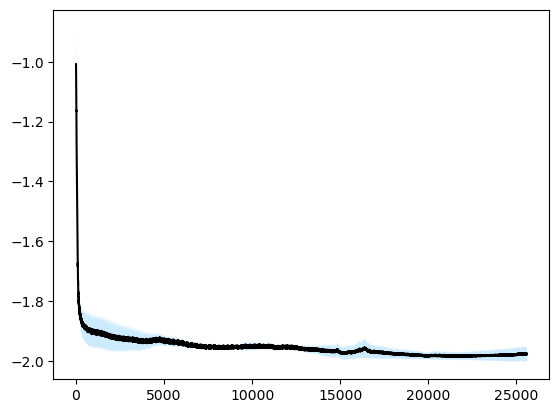

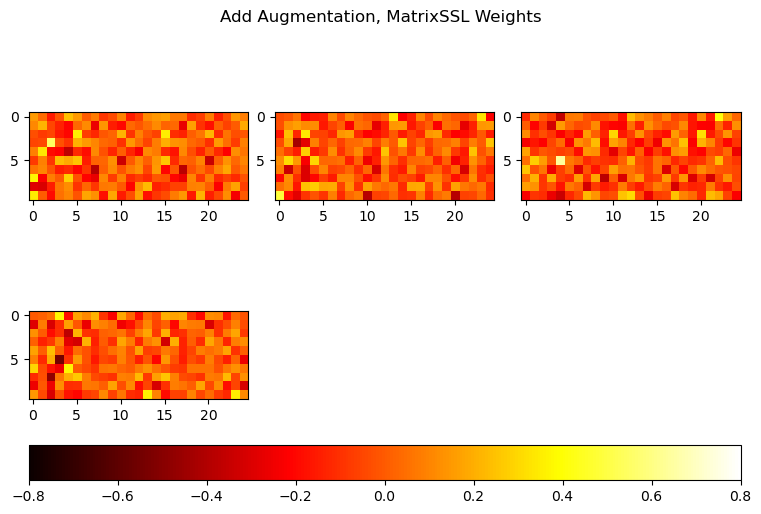

In [8]:
# aug=add, d=25, k=10, embd=10, bs=256, mssla
dirs = [
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4'
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Add Augmentation, MatrixSSL Weights')

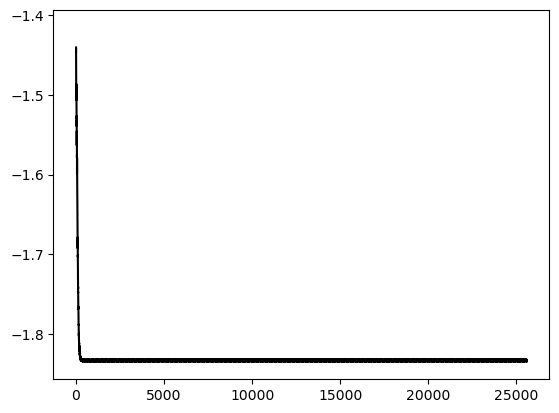

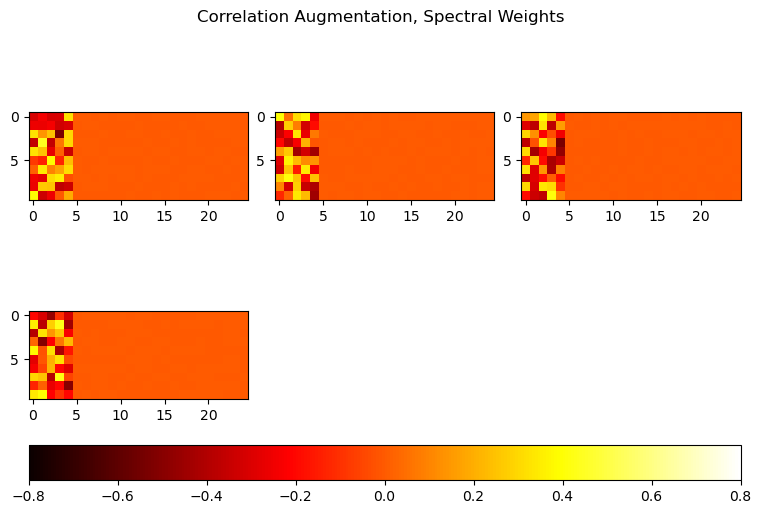

In [10]:
# aug=corr, d=25, k=10, embd=10, bs=256, spectral
dirs = [
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4'
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Correlation Augmentation, Spectral Weights')

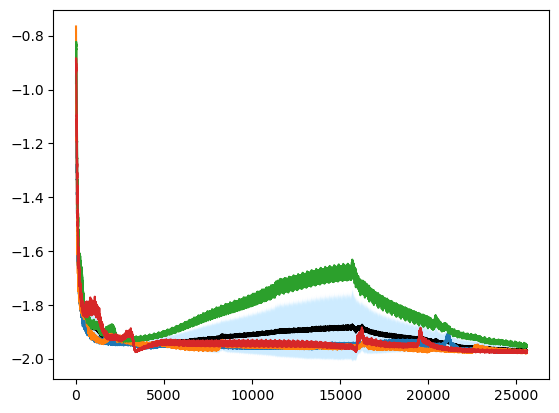

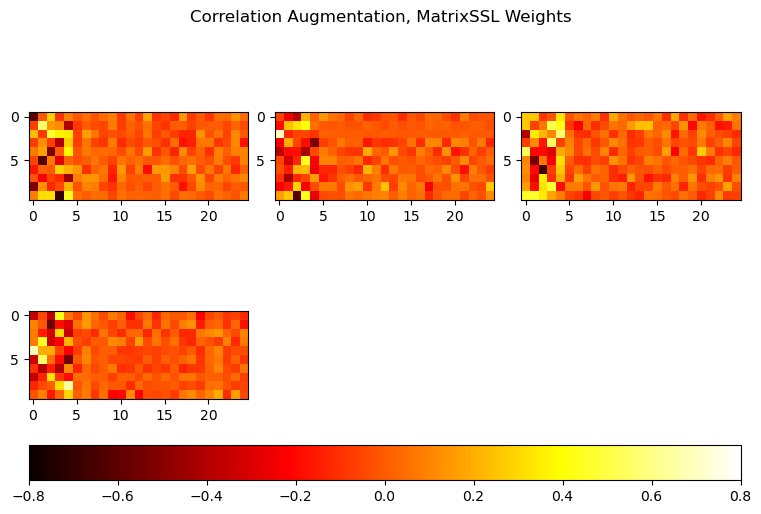

In [12]:
# aug=corr, d=25, k=10, embd=10, bs=256, mssla
dirs = [
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=True)
show_weights(dirs, subtitle=False, title='Correlation Augmentation, MatrixSSL Weights')

## Runs from single tau (from validation code scare)

Norm of 20 rows of Z1: tensor([5.2317, 5.2829, 3.2629, 5.7707, 6.2463, 4.1556, 4.0630, 5.7988, 5.2984,
        6.1979, 4.0702, 6.2182, 4.6822, 5.7751, 5.2846, 4.0808, 4.7194, 5.7919,
        6.5862, 5.8471])
Norm of 20 rows of Z1: tensor([7.1151, 4.4186, 6.1750, 4.4140, 7.8325, 5.8084, 6.7060, 5.9370, 3.8874,
        6.4622, 6.8644, 6.1967, 5.7001, 7.1757, 6.3181, 4.7599, 4.6628, 5.3345,
        7.1586, 4.8395])
Average norm of differences in embeddings (2 runs): 0.9445189237594604, embed dim = 10


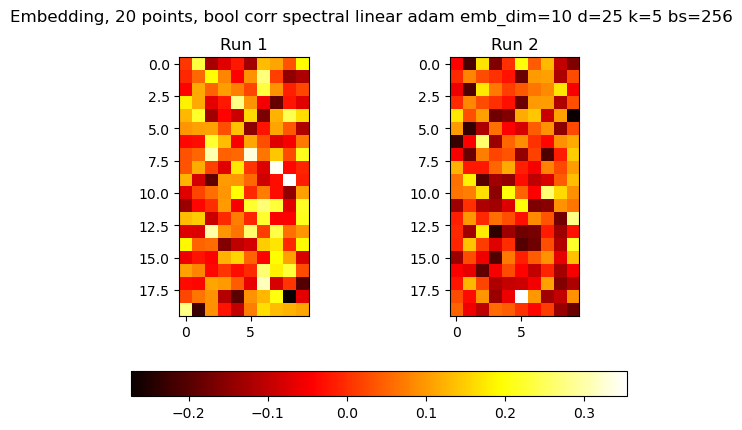

Average Frobenius norm of differences in covariances (2 runs): 2.824920415878296, embed dim = 10


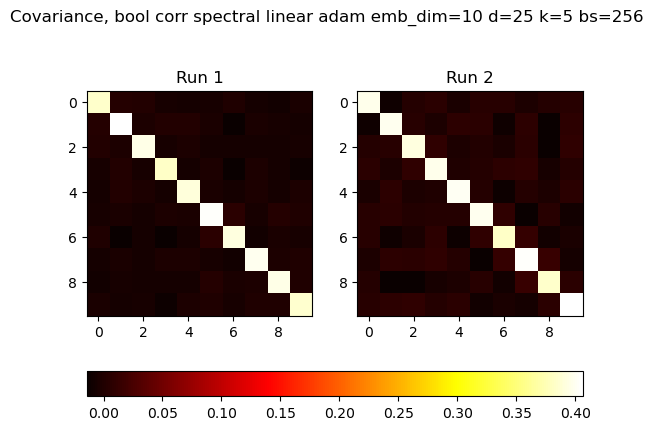

In [6]:
# SPECTRAL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run6',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

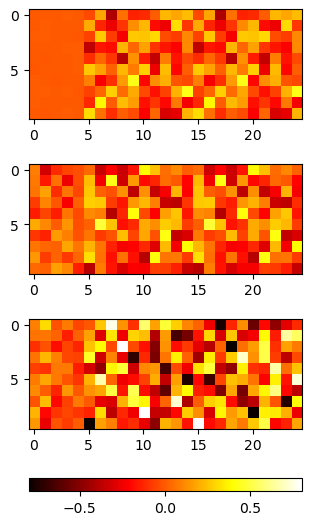

In [12]:
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run6',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run7',
]
show_weights(*dirs, subtitle=False, title=False)

Norm of 20 rows of Z1: tensor([1.9605, 1.9482, 1.9753, 1.9702, 1.9601, 1.9802, 1.9392, 1.9470, 1.9994,
        1.9509, 1.9704, 1.9454, 1.9936, 1.9736, 1.9942, 1.9946, 1.9918, 1.9782,
        2.0029, 1.9805])
Norm of 20 rows of Z1: tensor([1.9235, 1.9594, 1.9319, 1.9546, 1.9437, 1.9200, 1.9300, 1.9302, 1.9663,
        1.9013, 1.9555, 1.9580, 1.9633, 1.9622, 1.9352, 1.9364, 1.9470, 1.9596,
        1.9458, 1.9451])
Average norm of differences in embeddings (2 runs): 0.012446294538676739, embed dim = 10


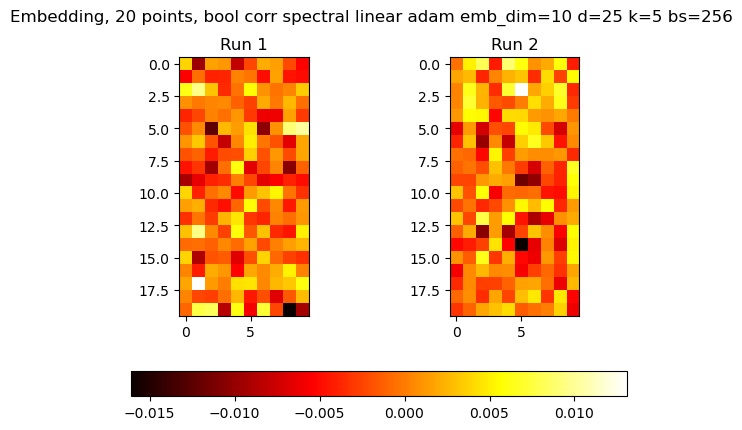

Average Frobenius norm of differences in covariances (2 runs): 0.00014628187636844814, embed dim = 10


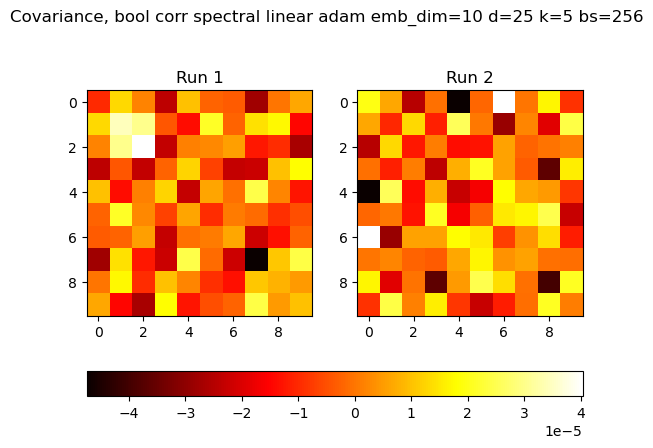

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


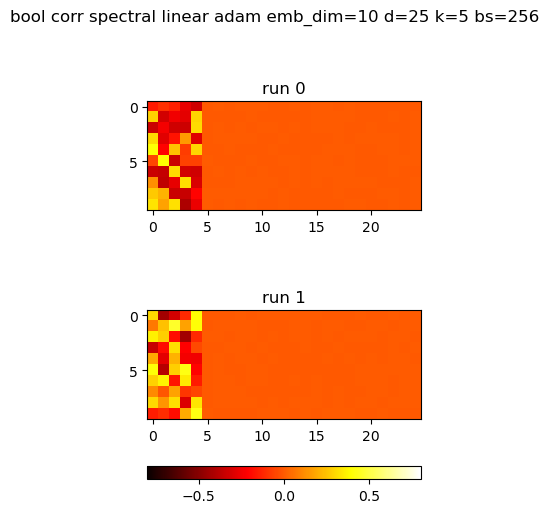

In [5]:
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run8',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run9',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

## Single $\tau$ for all dimensions, embd = h, $\tau \in [-1, 1]$
Ran into unstable solutions, i.e multiple runs converged to different final solutions. I reckon this is because of the same tau being used acros all dimensions

### SPECTRAL

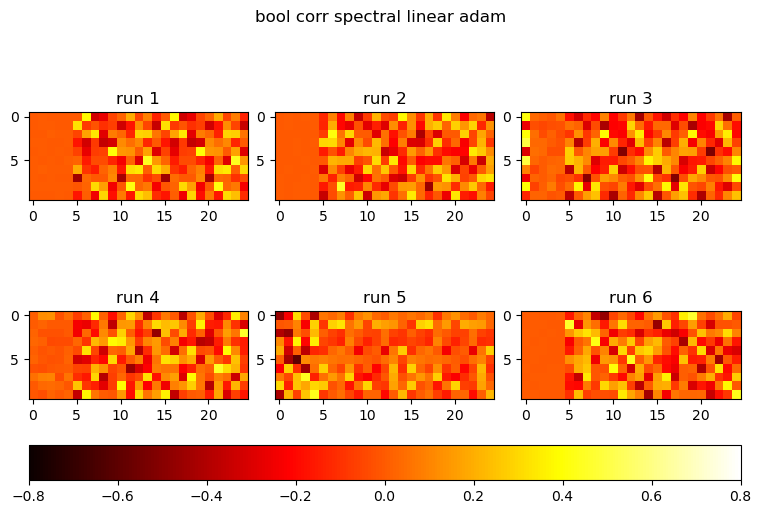

In [11]:
# WEIGHT MATRICES: spectral, embd=10(=h), single tau for all dims
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run6',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(dirs, subtitle=True, title=True)

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


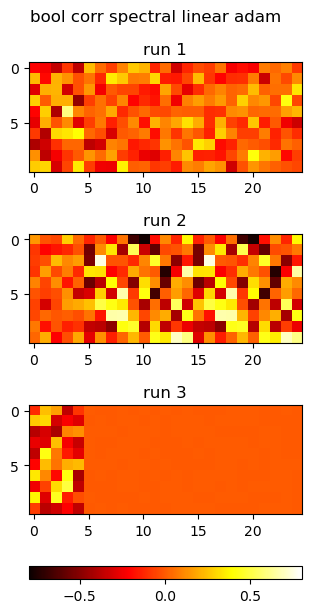

In [4]:
# more spectral runs, to show existence of ignoring augmented dims
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run7',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run8',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run9',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

In [6]:
# TEST SCORES: spectral runs, single tau for all dims, embd=h
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run6',
]
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for Spectral (Corr, Single Tau for all dims): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for Spectral (Corr, Single Tau for all dims): [0.6784800291061401, 0.46320000290870667, 0.7399200201034546, 0.5401600003242493, 0.6840000152587891, 0.5114799737930298]
Test accuracy average: 0.6028733253479004


### MSSL

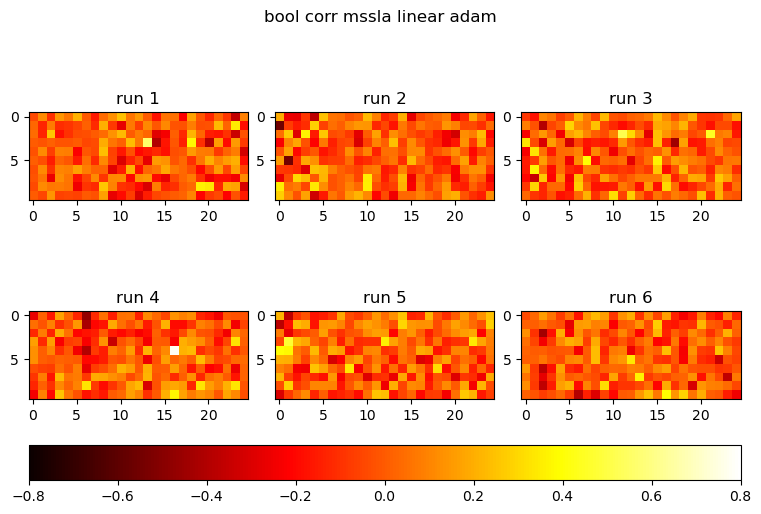

In [10]:
# WEIGHT MATRICES: MSSL, embd=10(=h), single tau for all dims
dirs = [
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run6',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(dirs, subtitle=True, title=True)

In [7]:
# TEST SCORES: mssl runs, single tau for all dims, embd=h
dirs = [
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run6',
]
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for MSSL (Corr, Single Tau for all dims): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for MSSL (Corr, Single Tau for all dims): [0.6747599840164185, 0.5906400084495544, 0.6885600090026855, 0.6376399993896484, 0.6716399788856506, 0.4745599925518036]
Test accuracy average: 0.6229666471481323


Suspect multiple solutions may have to do with there being many cases where the sum of the natural boolean values for augmented dimensions are already 0.. Note this is a dataset property, so the specific run here used doesnt matter

In [9]:
k = 5
h = 10
for i in range(6):
    dirname = f'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run{i+1}'
    run_dict = torch.load(os.path.join(dirname, 'run_dict'))
    x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][0]
    sums1 = torch.sum(x1[:, k:], dim=1)
    sums2 = torch.sum(x2[:, k:], dim=1)
    zerocount1 = torch.sum(sums1 == 0)
    # zerocount2 = torch.sum(sums2 == 0)
    print(f'Run {i+1} has {zerocount1} many zeros out of {x1.shape[0]}')
    # print(sums1[:20] == 0)
    # if i == 1:
    #     break


Run 1 has 8526 many zeros out of 65536
Run 2 has 11457 many zeros out of 65536
Run 3 has 8931 many zeros out of 65536
Run 4 has 11366 many zeros out of 65536
Run 5 has 9336 many zeros out of 65536
Run 6 has 8704 many zeros out of 65536


Norm of 20 rows of Z1: tensor([1.9127, 1.7239, 1.8628, 2.6317, 1.6249, 1.5270, 1.3455, 1.2087, 0.9808,
        1.8598, 1.7726, 1.4879, 0.9806, 1.6942, 2.1309, 0.3308, 2.0550, 2.1921,
        1.1300, 0.9972])
Average norm of differences in embeddings (1 runs): 0.12800082564353943, embed dim = 5


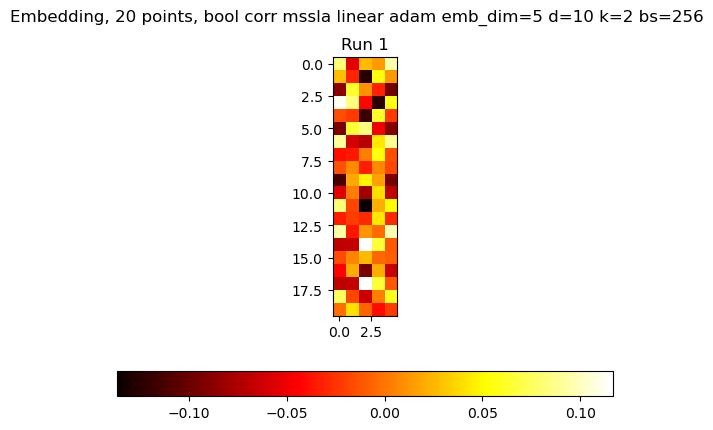

Average Frobenius norm of differences in covariances (1 runs): 0.21737602353096008, embed dim = 5


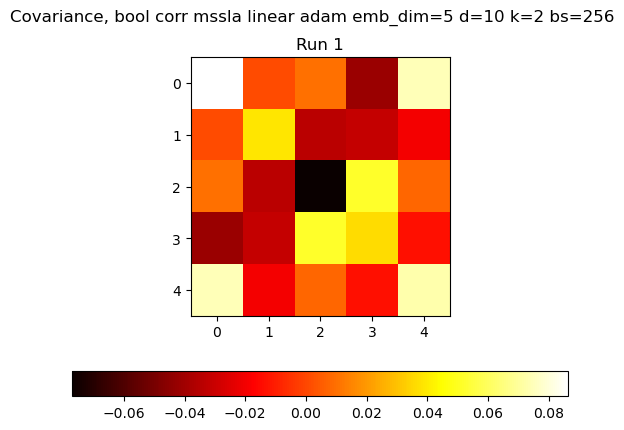

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


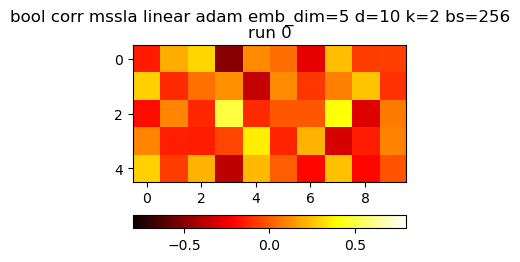

In [14]:
# MSSL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/mssla_linear_adam_emb_dim=5_d=10_k=2_bs=256_run1'
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

## Different $\tau$ per dimensions, set emb dim = k + h, $\tau \in [-1, 1]$ : Weights +  Test Accs
Changing this back intuitively forces weights to 0 in spectral, avoiding the weird cases we get when we use a single tau for all dimensions (and adjust embedding dimensions to be larger to properly learn spurious sum for bool corr augmentation)

### SPECTRAL
As expected, spectral consistently ignores augmented dimensions and only cares about augmented dimensions

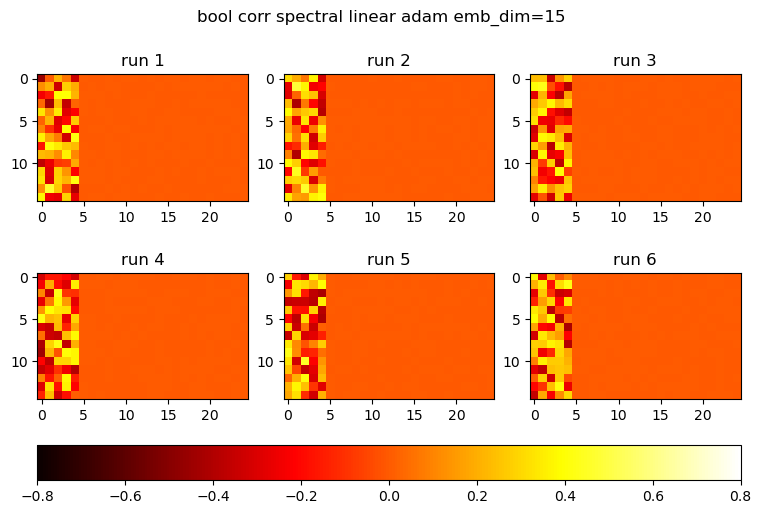

In [9]:
# WEIGHT MATRICES: bool corr, different tau per dimension, embd 15, spectral
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6'
]
show_weights(dirs, plot_weights=True, subtitle=True, title=True)

In [8]:
# DOWNSTREAM ACCURACY for spectral, embd15, different tau per dimension
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for Spectral (Corr, Diff Tau across dims, embd=k+h): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for Spectral (Corr, Diff Tau across dims, embd=k+h): [0.520039975643158, 0.5641599893569946, 0.5297999978065491, 0.5288400053977966, 0.5414800047874451, 0.508679986000061]
Test accuracy average: 0.5321666598320007


Interestingly, spectral is doing almost random guessing downstream!

### MSSL
MSSL learns some amount of the augmented dimensions, but still appears to give most weight to the unaugmented dimensions.

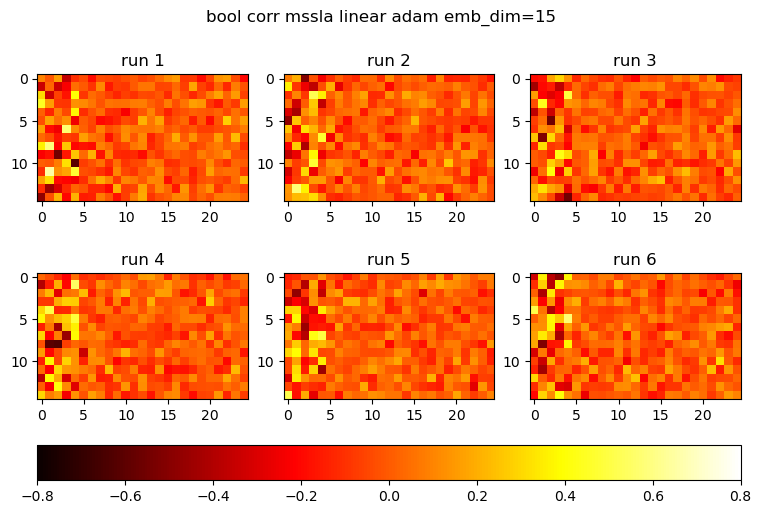

In [12]:
# WEIGHT MATRICES: bool corr, different tau per dimension, embd 15, mssla
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6'
]
show_weights(dirs, plot_weights=True, subtitle=True, title=True)

In [13]:
# DOWNSTREAM ACCURACY for mssla, embd15, different tau per dimension
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for MSSL (Corr, Diff Tau across dims, embd=k+h): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for MSSL (Corr, Diff Tau across dims, embd=k+h): [0.6060799956321716, 0.6015599966049194, 0.5016000270843506, 0.6048799753189087, 0.5853599905967712, 0.6520799994468689]
Test accuracy average: 0.591926634311676


MSSL appears to perform very slightly better downstream than Spectral.

## Varying tau ranges (different tau per dimension): Weights + Test Accs
Given results that we expect (and perhaps better performance from MSSL!), let's investigate whether varying the range of tau can give us better counterexamples, or tell us what varying tau does to representations. Four runs each.

### SPECTRAL

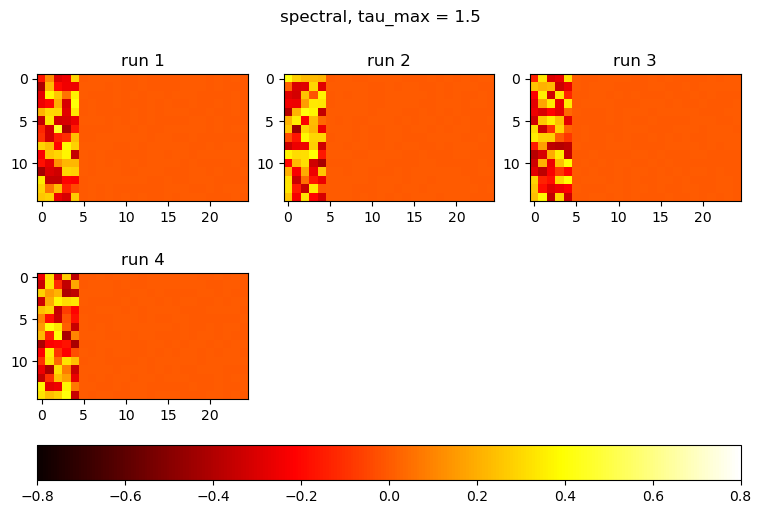

In [18]:
dirs = [
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run1',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run2',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run3',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 1.5')

In [20]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5547999739646912, 0.4942399859428406, 0.46827998757362366, 0.5093600153923035]
Average acciracy: 0.5066699981689453


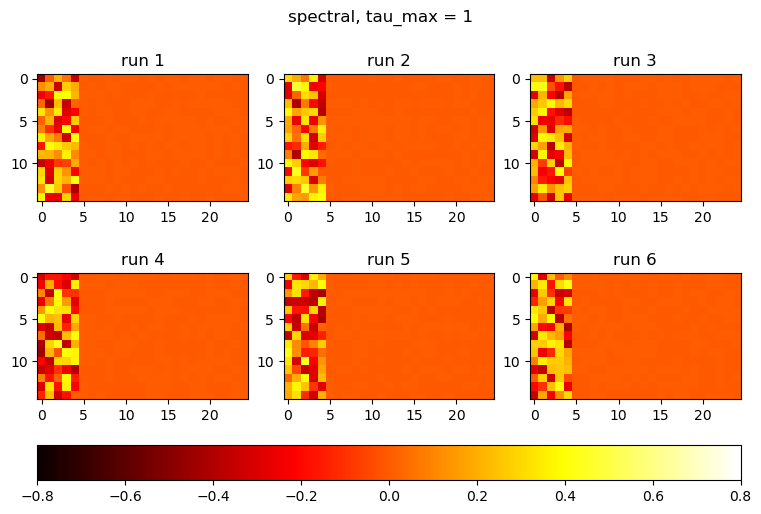

In [21]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 1')

In [22]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5545600056648254, 0.4943599998950958, 0.5552800297737122, 0.5115200281143188, 0.5138400197029114, 0.5763599872589111]
Average acciracy: 0.534320056438446


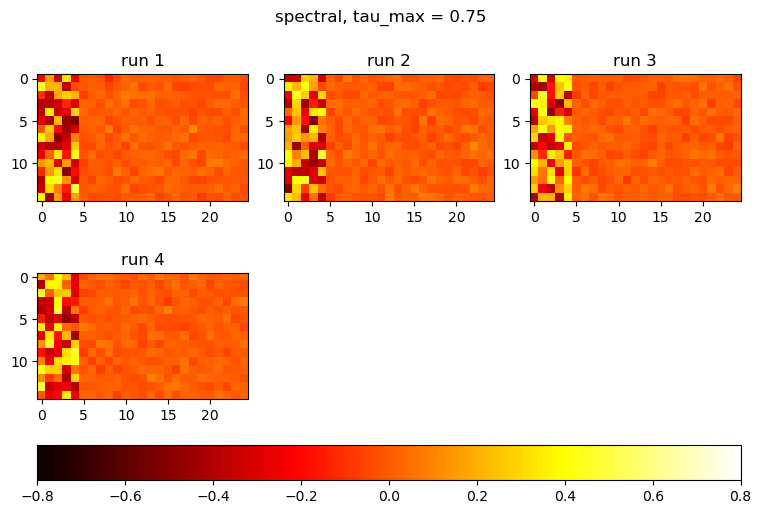

In [23]:
dirs = [
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run1',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run2',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run3',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.75')

In [24]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5557199716567993, 0.5588399767875671, 0.5929200053215027, 0.5027199983596802]
Average acciracy: 0.5525499582290649


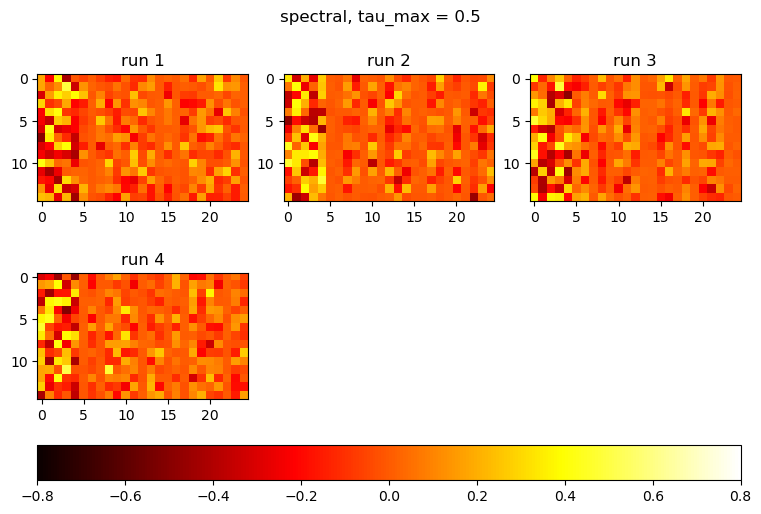

In [25]:
dirs = [
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run1',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run2',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run3',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.5')

In [26]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5523999929428101, 0.5932400226593018, 0.5820000171661377, 0.593280017375946]
Average acciracy: 0.5802299976348877


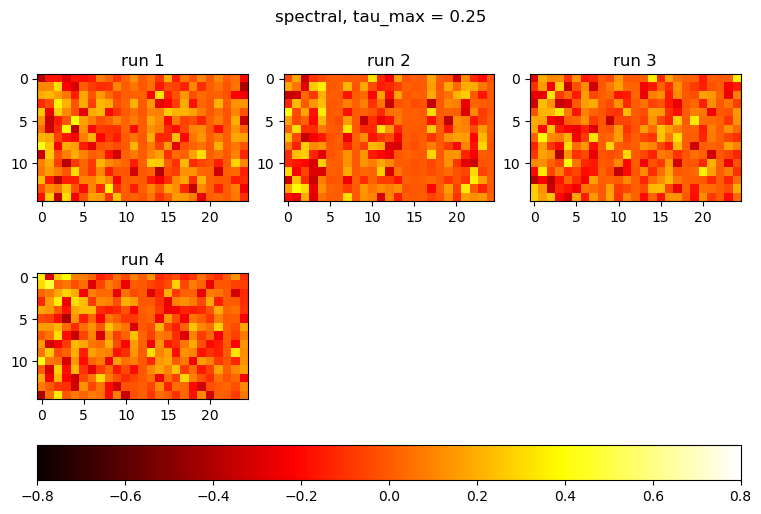

In [27]:
dirs = [
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run1',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run2',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run3',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.25')

In [28]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5670400261878967, 0.6345599889755249, 0.5628399848937988, 0.6446800231933594]
Average acciracy: 0.6022800207138062


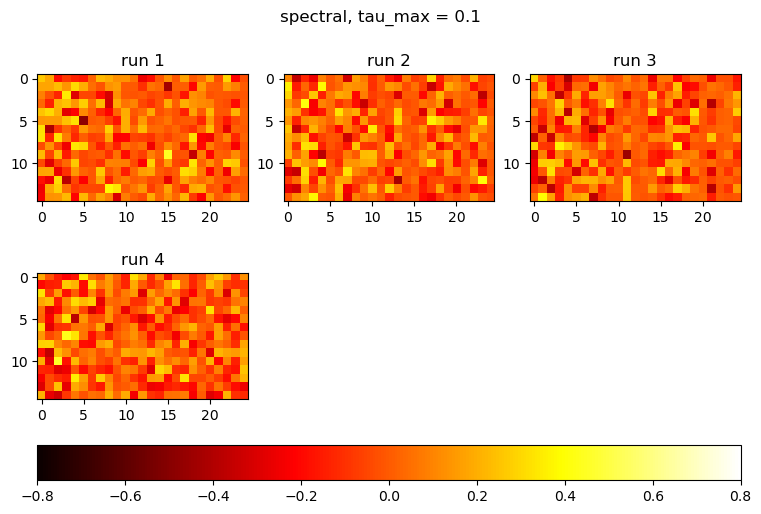

In [29]:
dirs = [
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run1',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run2',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run3',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.1')

In [30]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.7208799719810486, 0.5481600165367126, 0.5992400050163269, 0.6312400102615356]
Average acciracy: 0.6248799562454224


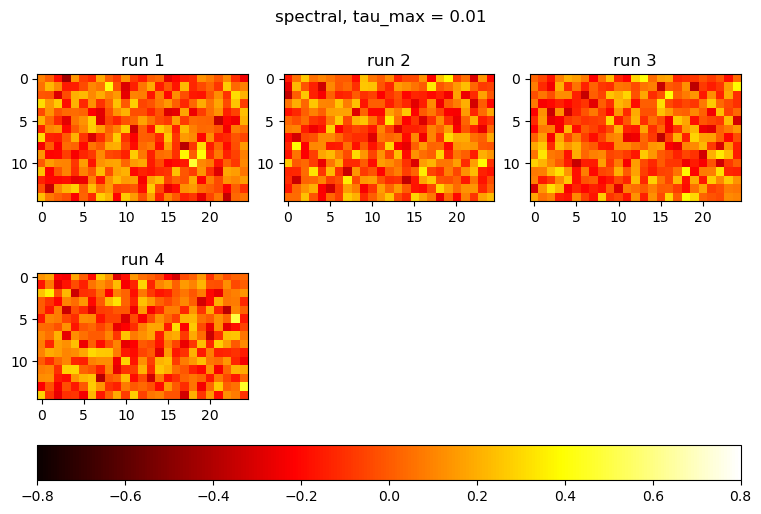

In [31]:
dirs = [
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run1',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run2',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run3',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.01')

In [32]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.561519980430603, 0.7379999756813049, 0.6629199981689453, 0.6312400102615356]
Average acciracy: 0.648419976234436


### MSSL

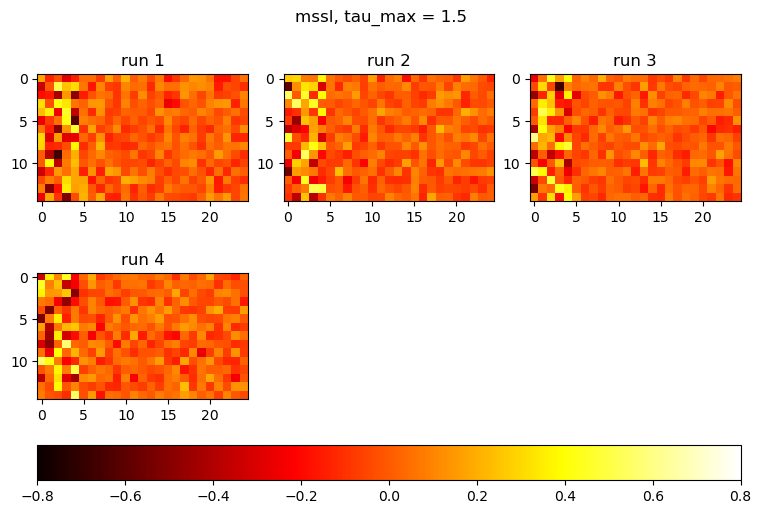

In [33]:
dirs = [
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run1',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run2',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run3',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 1.5')

In [34]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5290399789810181, 0.6737200021743774, 0.5184000134468079, 0.5665599703788757]
Average acciracy: 0.5719299912452698


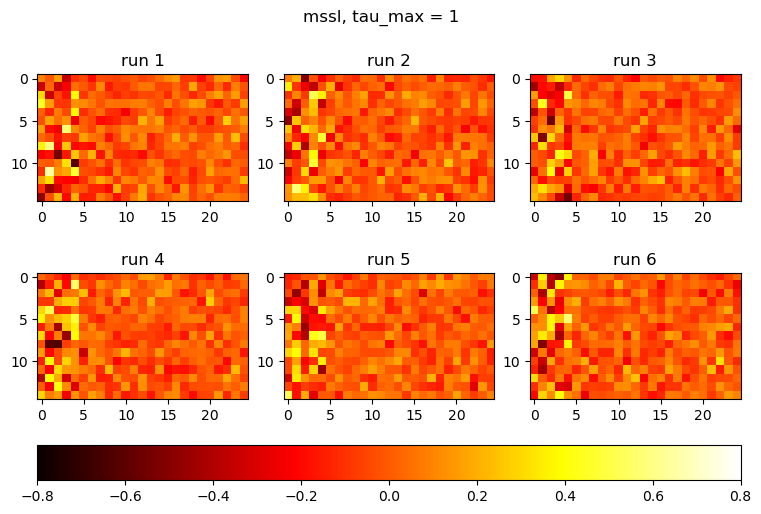

In [37]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 1')

In [38]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.6023600101470947, 0.6073600053787231, 0.5255600214004517, 0.616159975528717, 0.604200005531311, 0.5157600045204163]
Average acciracy: 0.5785666108131409


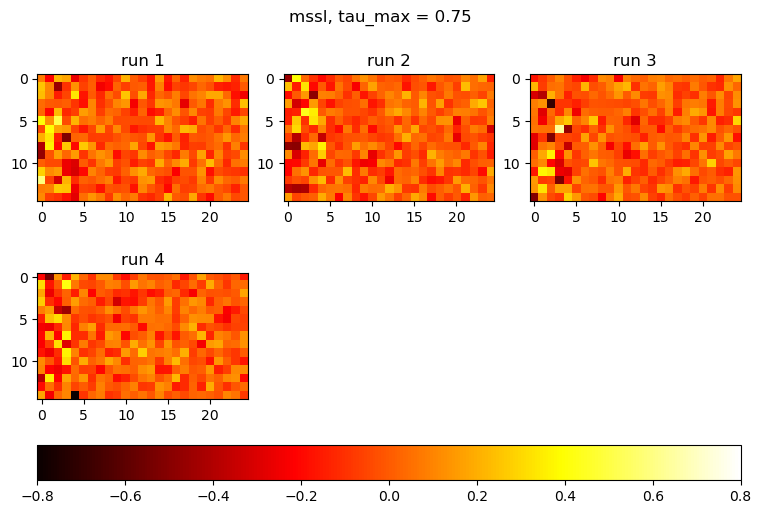

In [39]:
dirs = [
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run1',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run2',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run3',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.75')

In [40]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5317599773406982, 0.5280399918556213, 0.5484399795532227, 0.5960400104522705]
Average acciracy: 0.551069974899292


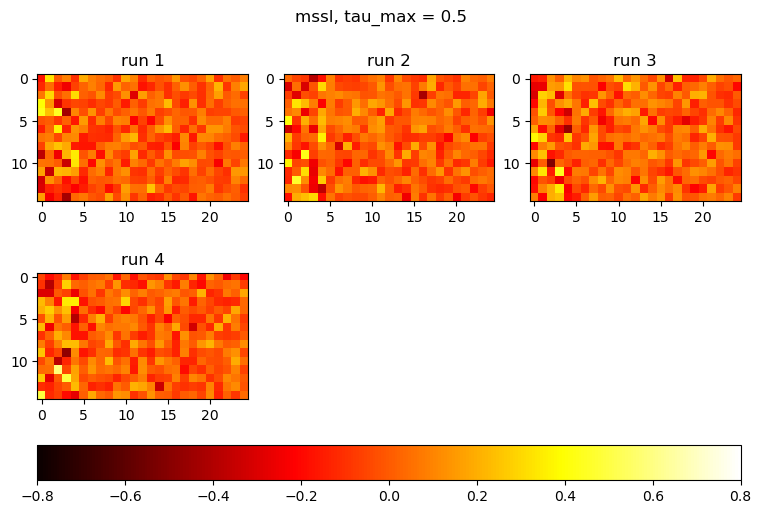

In [41]:
dirs = [
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run1',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run2',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run3',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.5')

In [42]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5181599855422974, 0.6031200289726257, 0.6420800089836121, 0.47699999809265137]
Average acciracy: 0.5600900053977966


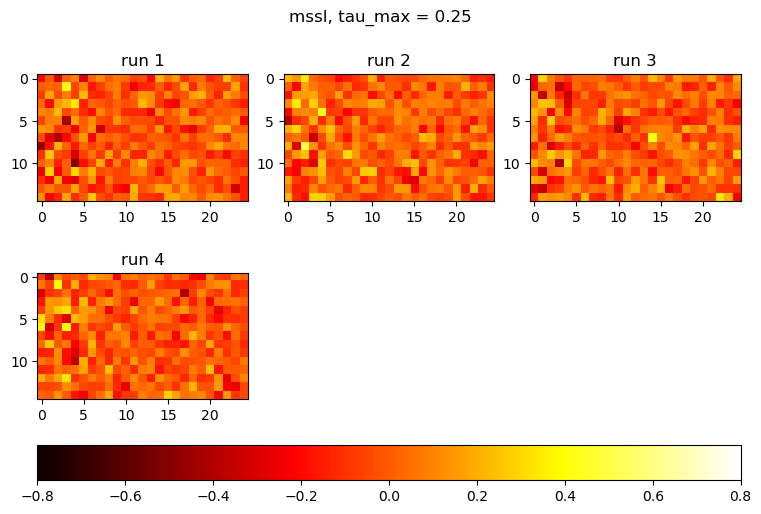

In [43]:
dirs = [
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run1',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run2',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run3',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.25')

In [44]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.679639995098114, 0.6543200016021729, 0.6047599911689758, 0.6159200072288513]
Average acciracy: 0.6386600136756897


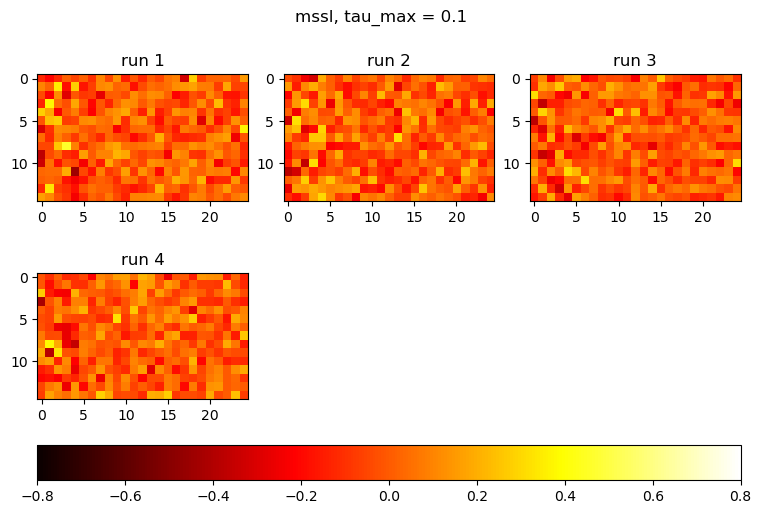

In [45]:
dirs = [
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run1',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run2',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run3',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.1')

In [46]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5942800045013428, 0.5461999773979187, 0.622160017490387, 0.6134799718856812]
Average acciracy: 0.5940300226211548


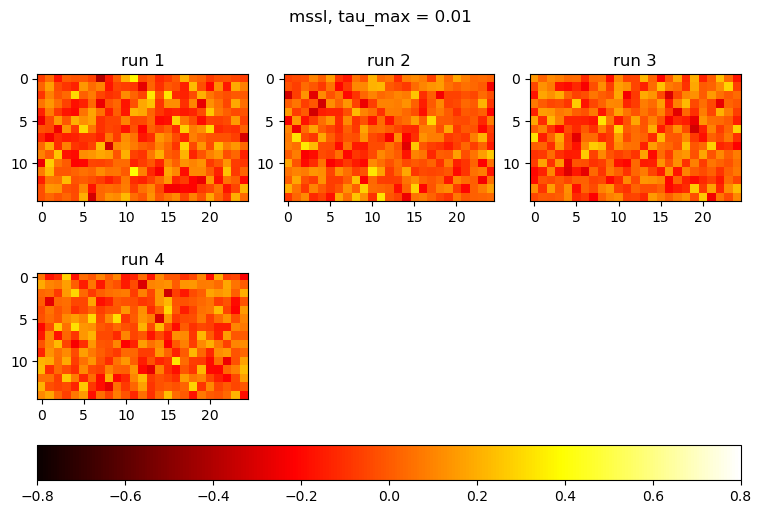

In [47]:
dirs = [
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run1',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run2',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run3',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.01')

In [48]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5418800115585327, 0.6626399755477905, 0.5189200043678284, 0.5922399759292603]
Average acciracy: 0.5789200067520142


## Weights + Test Accs for Different Tasks (embd=15)

### CORR, tau_max = 1.0 for all runs.

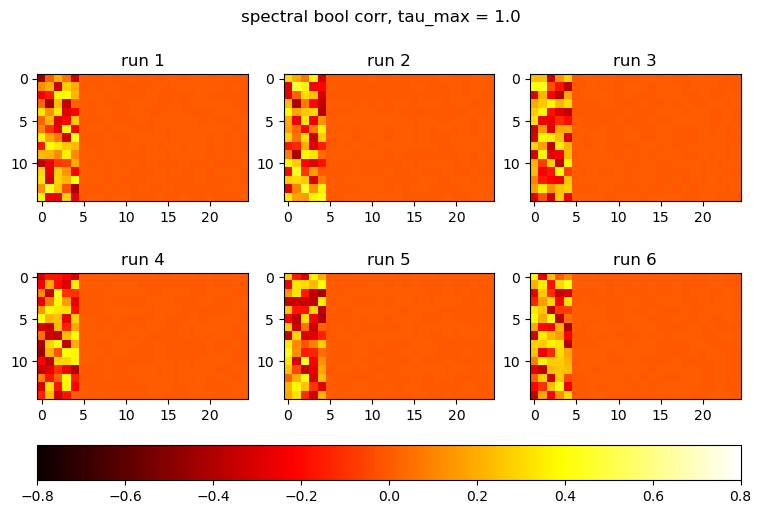

In [13]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral bool corr, tau_max = 1.0')

In [ ]:
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

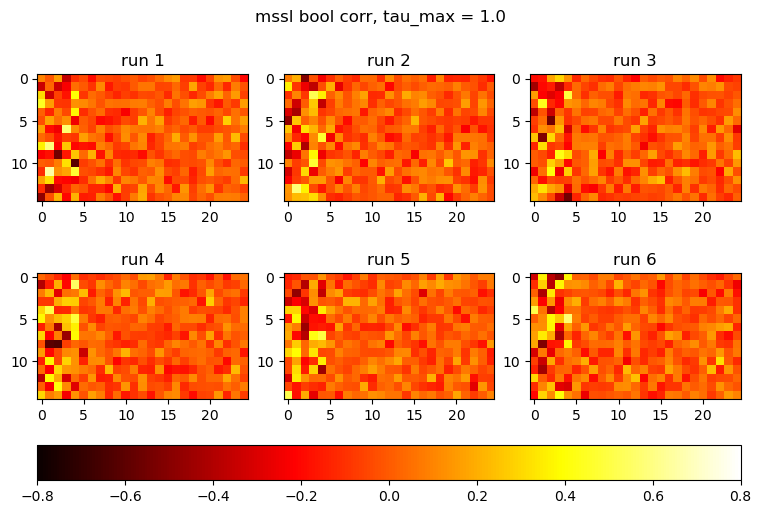

In [14]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl bool corr, tau_max = 1.0')

In [ ]:
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

### ADD

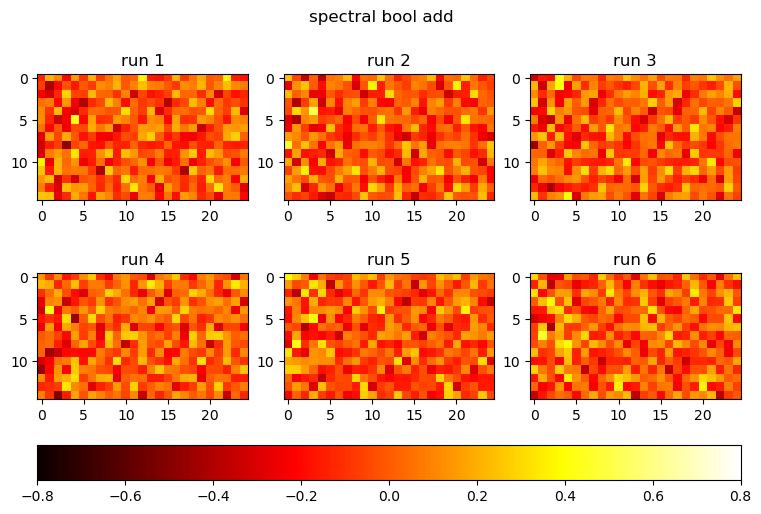

In [15]:
dirs = [
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral bool add')

In [ ]:
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

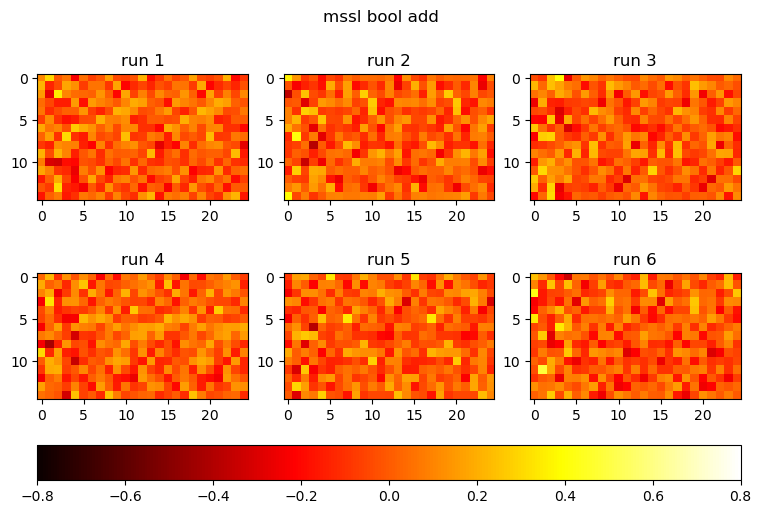

In [16]:
dirs = [
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl bool add')

In [ ]:
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

## Plot Assumptions (for embd=15)

Norm of 20 rows of Z1 for run 1: tensor([2.3334, 2.3352, 2.3327, 2.3746, 2.3212, 2.3535, 2.3532, 2.3725, 2.3260,
        2.3555, 2.3402, 2.3520, 2.3428, 2.3682, 2.3074, 2.3143, 2.2865, 2.3818,
        2.3341, 2.3545])
Average norm of differences in embeddings (6 runs): 0.016252363100647926, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.7474), tensor(0.6300), tensor(0.6994), tensor(0.6629), tensor(0.6223), tensor(0.7160)]


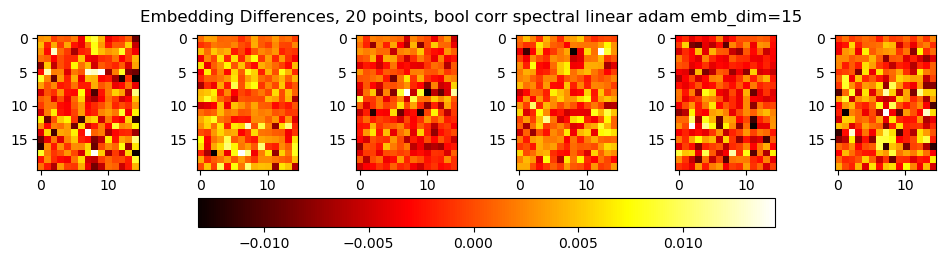

Norm of 100 rows of Z1 for run 1: tensor([2.3333, 2.3127, 2.3471, 2.3487, 2.3567, 2.3333, 2.3346, 2.2892, 2.3429,
        2.3352, 2.3517, 2.4085, 2.3054, 2.3381, 2.2875, 2.3974, 2.3195, 2.3706,
        2.3271, 2.3199, 2.3345, 2.3410, 2.3102, 2.3223, 2.3965, 2.3070, 2.3446,
        2.3647, 2.3289, 2.3772, 2.3302, 2.3548, 2.3735, 2.3628, 2.3579, 2.3186,
        2.3263, 2.3666, 2.3302, 2.3085, 2.3519, 2.3400, 2.3804, 2.3555, 2.3256,
        2.3470, 2.3658, 2.3512, 2.3194, 2.4116, 2.3723, 2.3280, 2.3638, 2.3481,
        2.3482, 2.3499, 2.3716, 2.4040, 2.3920, 2.3246, 2.3407, 2.3118, 2.3548,
        2.3642, 2.3627, 2.3323, 2.3495, 2.3024, 2.3869, 2.3361, 2.3709, 2.2890,
        2.3528, 2.3315, 2.3770, 2.3323, 2.3295, 2.3456, 2.3381, 2.3618, 2.3582,
        2.3850, 2.3255, 2.3018, 2.3285, 2.3333, 2.3382, 2.3576, 2.3597, 2.3055,
        2.3346, 2.3909, 2.3268, 2.3664, 2.3097, 2.3330, 2.3374, 2.3340, 2.3371,
        2.3015])
Average Frobenius norm of differences in covariances (6 runs): 0.0002

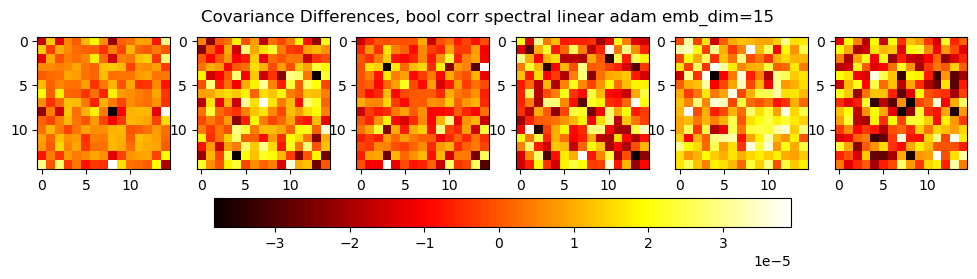

In [4]:
# SPECTRAL CORR
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Norm of 20 rows of Z1 for run 1: tensor([3.3936, 3.1132, 2.9115, 2.5323, 2.4782, 2.5228, 3.1377, 2.1670, 3.0571,
        2.5740, 3.3371, 2.7518, 3.2195, 3.2912, 3.1542, 3.3431, 3.4626, 3.2979,
        2.4883, 2.6073])
Average norm of differences in embeddings (6 runs): 1.3221406936645508, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.6873), tensor(0.7329), tensor(0.7535), tensor(0.6660), tensor(0.6124), tensor(0.7201)]


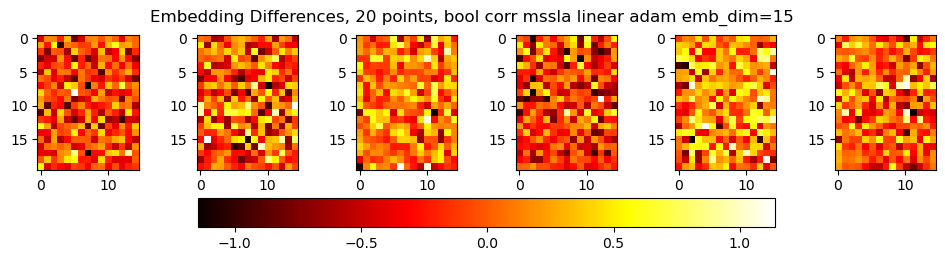

Norm of 100 rows of Z1 for run 1: tensor([3.6525, 2.7874, 3.1134, 2.5151, 3.7669, 2.6060, 2.8708, 3.3856, 3.5874,
        2.3653, 2.7586, 2.5580, 3.7634, 2.8387, 2.6066, 2.7552, 3.0442, 3.7020,
        2.6262, 3.1949, 3.3897, 3.2054, 2.8046, 3.4417, 2.7572, 2.7678, 2.4060,
        2.9776, 2.5876, 3.2978, 2.7575, 2.6352, 2.4812, 3.1337, 3.0986, 3.1742,
        2.8300, 3.2420, 3.1607, 2.6700, 3.2348, 3.9244, 2.9712, 2.9000, 3.4162,
        2.6406, 2.5598, 3.1607, 2.8676, 3.2714, 2.5063, 3.8457, 2.6725, 2.4811,
        2.4946, 2.9955, 2.6171, 3.2954, 3.4949, 2.7942, 2.5051, 3.1554, 3.0747,
        2.1939, 2.8964, 2.7059, 2.9723, 2.5300, 3.1149, 3.5595, 3.1656, 2.5892,
        3.1358, 3.6000, 4.5308, 2.4967, 3.8860, 2.3941, 3.1287, 2.9457, 3.2492,
        2.6064, 3.0268, 2.8179, 2.4910, 2.9354, 3.6411, 3.5177, 3.1119, 2.5693,
        3.1549, 2.9442, 3.3559, 3.3060, 2.6408, 2.5889, 3.5881, 2.5616, 2.2904,
        3.4032])
Average Frobenius norm of differences in covariances (6 runs): 0.0206

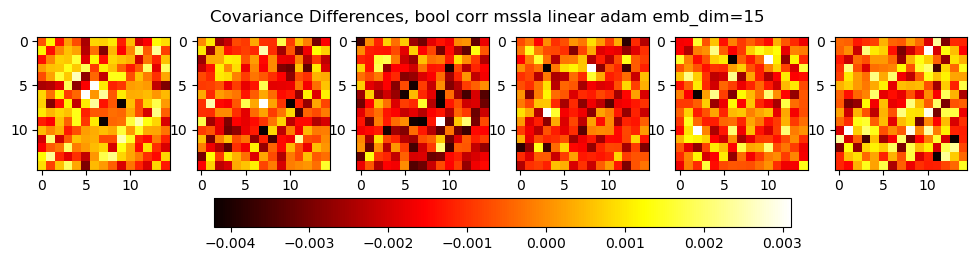

In [5]:
# MSSL CORR 
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Norm of 20 rows of Z1 for run 1: tensor([2.9601, 3.2972, 3.6766, 3.0396, 2.7475, 3.6995, 3.2402, 3.6878, 3.4575,
        3.7162, 3.6456, 3.4895, 3.6990, 3.3119, 3.2694, 3.7154, 3.2341, 3.2743,
        2.5537, 2.7035])
Average norm of differences in embeddings (6 runs): 0.010163584724068642, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.7496), tensor(0.7987), tensor(0.6701), tensor(0.6847), tensor(0.5966), tensor(0.7484)]


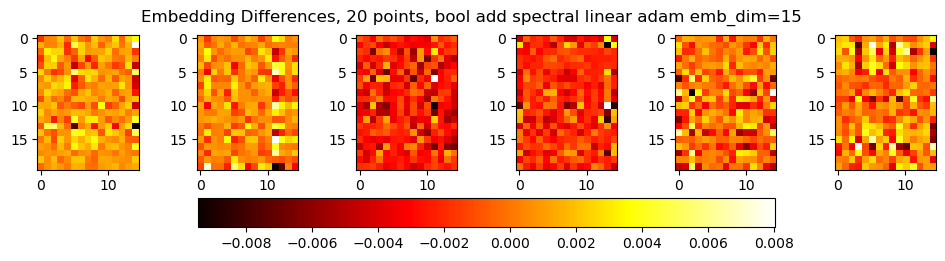

Norm of 100 rows of Z1 for run 1: tensor([3.2985, 3.2030, 3.3700, 2.7850, 3.5363, 3.0088, 2.7914, 2.6467, 3.2554,
        2.7729, 2.5508, 3.6872, 3.5237, 3.2844, 3.9194, 2.3669, 2.9568, 3.4531,
        2.6946, 2.8727, 3.2500, 3.5451, 3.1220, 3.4929, 3.2957, 3.0770, 3.2336,
        3.4898, 3.1038, 2.9524, 3.2379, 3.6452, 2.7998, 2.9424, 2.5927, 3.0702,
        3.0169, 3.8365, 3.3565, 3.0356, 2.7752, 3.6109, 3.2318, 3.8889, 3.5377,
        3.4145, 2.9792, 3.0232, 3.0412, 3.4192, 3.0475, 3.4090, 3.5243, 3.4771,
        3.0194, 3.5233, 2.5731, 3.1239, 3.2288, 3.3235, 2.6747, 3.4139, 3.2725,
        3.2855, 2.9966, 2.9878, 2.9808, 3.6664, 2.7489, 3.2696, 2.8220, 3.0198,
        3.4100, 2.7912, 3.2707, 3.5250, 2.9633, 3.5120, 3.4044, 3.0295, 2.4367,
        3.2905, 2.9563, 3.2374, 3.0704, 3.4176, 2.9126, 3.2568, 2.7238, 3.4147,
        3.2735, 3.1571, 2.7443, 3.7069, 3.2101, 3.2389, 3.2691, 2.5216, 3.2353,
        3.2284])
Average Frobenius norm of differences in covariances (6 runs): 0.0002

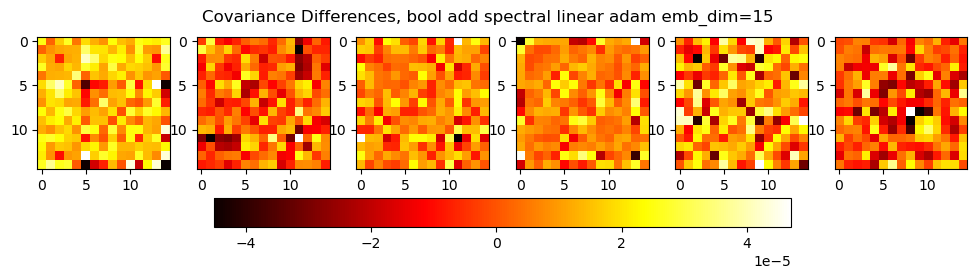

In [6]:
# SPECTRAL ADD
dirs = [
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Average norm of differences in embeddings (4 runs): 0.009822060354053974, embed dim = 10


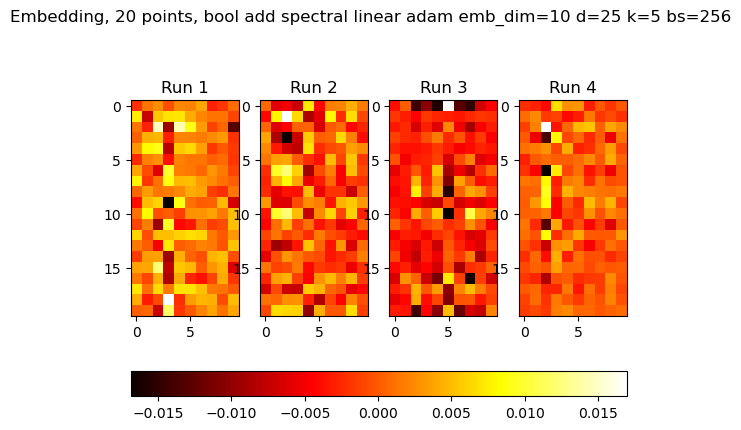

Average Frobenius norm of differences in covariances (4 runs): 0.00014511648623738438, embed dim = 10


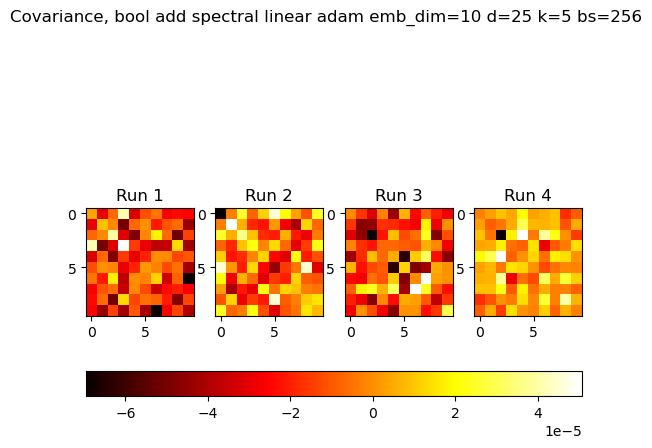

In [ ]:
# SPECTRAL ADD
dirs = [
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

Average norm of differences in embeddings (4 runs): 0.09455543011426926, embed dim = 10


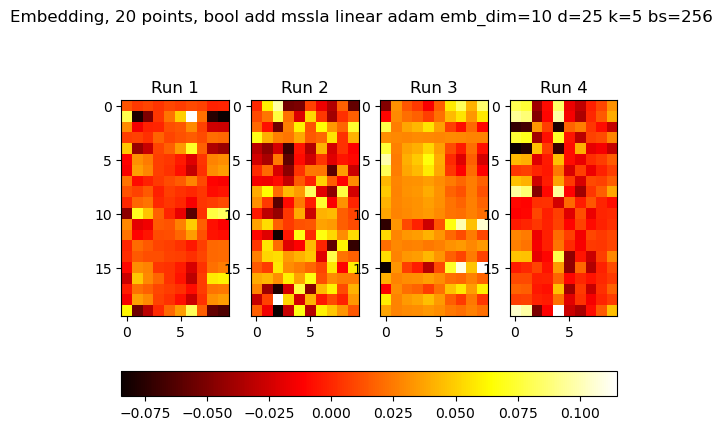

Average Frobenius norm of differences in covariances (4 runs): 0.001541726989671588, embed dim = 10


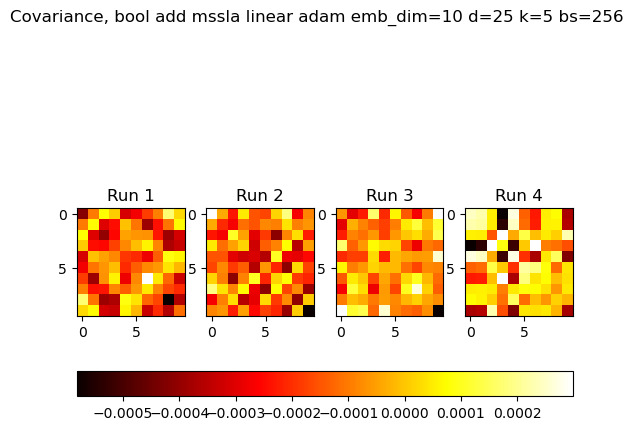

In [ ]:
# MSSL ADD
dirs = [
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

## Meta: Checks to see validity of test accuracy code
Since spurious sum can give 0, we by convention set label to be 1 if the sum of natural data is 0. Wanted to see if this would lead to weird issues along the way..

In [33]:
# Look into how often incorrect predictions were due to spursum = 0 cases
# MSSLA
spsum_is0_mask = (torch.sum(spur_test[:, 5:], dim=1) == 0)
print("Wrong test predictions due to spurious sum = 0 in labeling function:")
for idx, (backbone, linear) in enumerate(zip(backbones, classifiers)):
    out = linear(backbone(spur_test)).flatten()
    out[out == 0] = 1 # also included same 'convention' in labeling - not sure if this makes sense or not.
    pred = (torch.sign(out) + 1)/2
    wrongs = (spur_test_labels != pred)
    wrong_for_spsum0 = torch.sum(wrongs[spsum_is0_mask]).item()
    total_wrong = torch.sum(wrongs).item()
    total_spsum_is0 = torch.sum(spsum_is0_mask)
    
    # print(f'Run {idx + 1}, out of total wrong: {wrong_for_spsum0} / {total_wrong} = {wrong_for_spsum0/total_wrong}')
    print(f'Run {idx + 1}, out of total spsum=0: {wrong_for_spsum0} / {total_spsum_is0} = {wrong_for_spsum0/total_spsum_is0}')
    
    

Wrong test predictions due to spurious sum = 0 in labeling function:
Run 1, out of total spsum=0: 1767 / 4416 = 0.40013587474823
Run 2, out of total spsum=0: 724 / 4416 = 0.16394928097724915
Run 3, out of total spsum=0: 1981 / 4416 = 0.4485960304737091
Run 4, out of total spsum=0: 2778 / 4416 = 0.6290761232376099
Run 5, out of total spsum=0: 2108 / 4416 = 0.47735509276390076
Run 6, out of total spsum=0: 378 / 4416 = 0.08559782803058624


In [15]:
spursums_test = torch.sum(spur_test[:, 5:], dim=1)
torch.sum(spursums_test == 0)/spur_test.shape[0]

tensor(0.1766)

In [9]:
# MSSL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5'
]
test_accs, avg_acc = evaluate_embeddings(dirs, val=spur_val, val_labels=spur_val_labels, test=spur_test, test_labels=spur_test_labels)

FileNotFoundError: [Errno 2] No such file or directory: './outputs/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5/run_dict'

In [11]:
test_accs, avg_acc

([tensor(0.1612)], tensor(0.1612))

In [5]:
# SPECTRAL, ADD, INVKD, TEST SCORES
dirs = [
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
test_accs, avg_acc = evaluate_embeddings(*dirs, val=invkd_val, val_labels=invkd_val_labels, test=invkd_test, test_labels=invkd_test_labels)

NameError: name 'evaluate_embeddings' is not defined

In [131]:
test_accs, avg_acc

([tensor(0.2874), tensor(0.4137), tensor(0.3263), tensor(0.1790)],
 tensor(0.3016))

In [100]:
# ADD, INVKD SPECTRAL TEST SCORES


torch.Size([50000])

In [ ]:
# ADD, INVKD MSSL TEST SCORES

In [ ]:
# ADD, SPUR SPECTRAL TEST SCORES

In [ ]:
# ADD, SPUR MSSL TEST SCORES

In [ ]:
# CORR, INVKD SPECTRAL TEST SCORES

In [ ]:
# CORR, INVKD MSSL TEST SCORES